# Bayesian filtering: tracking multiple sensors using radio pings

Load the libraries we need

In [1]:
import math
import time
import sys
import numpy as np
from scipy import misc
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import patches

## Create the data structures

Define the state variables $\mathbf{X}$ and the sensor variables $\mathbf{Y}$. In this case, the state variables consist of the positions of the different sensors (in feet) along two dimensions (denoted $h$ and $v$ to avoid confusion with $\mathbf{X}$ and $\mathbf{Y}$). There are moving sensors, which start out at a random spot in the room and then follow a random walk (these could be child sensors, material sensors, or teacher sensors), and stationary sensors, which start out near pre-defined guesses and then just fluctuate their locations while remaining near those guesses (these could be area sensors. We have artifically added this jitter for technical reasons to help the particle filter converge. The sensor variables are the status of the ping between each pair of sensors (received or not received) and, if received, the RSSI (in DB) of the received ping.

Define the number of each type of sensor.

In [2]:
num_moving_sensors = 3
num_stationary_sensors = 4 # Currently must be 4 or fewer because we manually place them from a fixed list of 4 positions

Define the names of the sensors.

In [3]:
sensor_names = []

for moving_sensor_index in range(num_moving_sensors):
    sensor_names.append('Moving sensor {}'.format(moving_sensor_index + 1))

for stationary_sensor_index in range(num_stationary_sensors):
    sensor_names.append('Stationary sensor {}'.format(stationary_sensor_index + 1))

num_sensors = len(sensor_names)

Define the names of the spatial dimensions.

In [4]:
dimension_names = [
    '$h$',
    '$v$'
]

num_dimensions = len(dimension_names)

Using the sensor names and the dimension names, define the names of the $\mathbf{X}$ variables (the state variables).

In [5]:
x_names = []

for sensor_index in range(num_sensors):
    for dimension_index in range(num_dimensions):
        x_names.append('{} {} position'.format(sensor_names[sensor_index],
                                                    dimension_names[dimension_index]))

Using the sensor names, define the names of the $\mathbf{Y}$ variables (the sensor variables).

In [6]:
y_discrete_names = []
y_continuous_names = []

for sending_sensor_index in range(num_sensors):
    receiving_sensor_range = range(num_sensors)
    del receiving_sensor_range[sending_sensor_index]
    for receiving_sensor_index in receiving_sensor_range:
        y_discrete_names.append('Status of ping from {} to {}'.format(sensor_names[sending_sensor_index],
                                                                           sensor_names[receiving_sensor_index]))        
        y_continuous_names.append('RSSI of ping from {} to {}'.format(sensor_names[sending_sensor_index],
                                                                           sensor_names[receiving_sensor_index]))        

Define the names of the different ping statuses.

In [7]:
ping_status_names = [
    'Received',
    'Not received'
]

Define constants for the number of $\mathbf{X}$ variables, the number of $\mathbf{Y}$ variables, and the number of ping statuses (since we'll need these in a bunch of places).

In [8]:
num_x_vars = len(x_names)
num_y_discrete_vars = len(y_discrete_names)
num_y_continuous_vars = len(y_continuous_names)

num_ping_statuses = len(ping_status_names)

Print out all of these variables to make sure they are what we expect.

In [9]:
x_names

['Moving sensor 1 $h$ position',
 'Moving sensor 1 $v$ position',
 'Moving sensor 2 $h$ position',
 'Moving sensor 2 $v$ position',
 'Moving sensor 3 $h$ position',
 'Moving sensor 3 $v$ position',
 'Stationary sensor 1 $h$ position',
 'Stationary sensor 1 $v$ position',
 'Stationary sensor 2 $h$ position',
 'Stationary sensor 2 $v$ position',
 'Stationary sensor 3 $h$ position',
 'Stationary sensor 3 $v$ position',
 'Stationary sensor 4 $h$ position',
 'Stationary sensor 4 $v$ position']

In [10]:
y_discrete_names

['Status of ping from Moving sensor 1 to Moving sensor 2',
 'Status of ping from Moving sensor 1 to Moving sensor 3',
 'Status of ping from Moving sensor 1 to Stationary sensor 1',
 'Status of ping from Moving sensor 1 to Stationary sensor 2',
 'Status of ping from Moving sensor 1 to Stationary sensor 3',
 'Status of ping from Moving sensor 1 to Stationary sensor 4',
 'Status of ping from Moving sensor 2 to Moving sensor 1',
 'Status of ping from Moving sensor 2 to Moving sensor 3',
 'Status of ping from Moving sensor 2 to Stationary sensor 1',
 'Status of ping from Moving sensor 2 to Stationary sensor 2',
 'Status of ping from Moving sensor 2 to Stationary sensor 3',
 'Status of ping from Moving sensor 2 to Stationary sensor 4',
 'Status of ping from Moving sensor 3 to Moving sensor 1',
 'Status of ping from Moving sensor 3 to Moving sensor 2',
 'Status of ping from Moving sensor 3 to Stationary sensor 1',
 'Status of ping from Moving sensor 3 to Stationary sensor 2',
 'Status of ping

In [11]:
y_continuous_names

['RSSI of ping from Moving sensor 1 to Moving sensor 2',
 'RSSI of ping from Moving sensor 1 to Moving sensor 3',
 'RSSI of ping from Moving sensor 1 to Stationary sensor 1',
 'RSSI of ping from Moving sensor 1 to Stationary sensor 2',
 'RSSI of ping from Moving sensor 1 to Stationary sensor 3',
 'RSSI of ping from Moving sensor 1 to Stationary sensor 4',
 'RSSI of ping from Moving sensor 2 to Moving sensor 1',
 'RSSI of ping from Moving sensor 2 to Moving sensor 3',
 'RSSI of ping from Moving sensor 2 to Stationary sensor 1',
 'RSSI of ping from Moving sensor 2 to Stationary sensor 2',
 'RSSI of ping from Moving sensor 2 to Stationary sensor 3',
 'RSSI of ping from Moving sensor 2 to Stationary sensor 4',
 'RSSI of ping from Moving sensor 3 to Moving sensor 1',
 'RSSI of ping from Moving sensor 3 to Moving sensor 2',
 'RSSI of ping from Moving sensor 3 to Stationary sensor 1',
 'RSSI of ping from Moving sensor 3 to Stationary sensor 2',
 'RSSI of ping from Moving sensor 3 to Stationar

In [12]:
num_x_vars

14

In [13]:
num_y_discrete_vars

42

In [14]:
num_y_continuous_vars

42

In [15]:
num_ping_statuses

2

## Create the probability models

The particle filter takes three probability models as inputs: the initial state model $f(\mathbf{X}_0)$, the transition model $f(\mathbf{X}_t | \mathbf{X}_{t-1})$, and the sensor response model $f(\mathbf{Y} | \mathbf{X})$. In this case, we define the room as a rectangle which is 20 feet wide and 10 feet high. The initial positions of the moving sensors are distributed uniformly within the room. The initial positions of the stationary sensors are placed near pre-defined guesses with Gaussian error. The transition model for the moving sensors is a two-dimensional random walk for each sensor. The transition model for the stationary sensors is a blend between their initial positions and a random walk with Gaussian fluctuations(we artifically introduce these slight fluctuations to help the particle filter converge). The sensor response model is that the sensors measure the status of the ping between each pair of sensors and, if the ping is received, the RSSI of the ping (in dB).

### Initial state model

Define a function that generates samples of the initial state $\mathbf{X}_0$. We'll need this both to generate our simulated data and as an input to the particle filter. Moving sensors are distributed uniformly throughout the room and the positions of the stationary sensors are sampled from a 2-d Gaussian distribution centered on their guesses. We include some additional machinery to allow for the possibility of no moving sensors or no stationary sensors.

In [16]:
room_size = np.array([20.0, 10.0])

In [17]:
stationary_sensor_position_guesses = room_size*np.array([[0.5, 1.0],
                                                         [0.5, 0.0],
                                                         [0.0, 0.5],
                                                         [1.0, 0.5]])[0:num_stationary_sensors]

In [18]:
stationary_sensor_position_guesses

array([[ 10.,  10.],
       [ 10.,   0.],
       [  0.,   5.],
       [ 20.,   5.]])

In [19]:
stationary_sensor_position_guess_error = 1.0

Plot the initial guesses for the positions of the stationary sensors, along with their error.

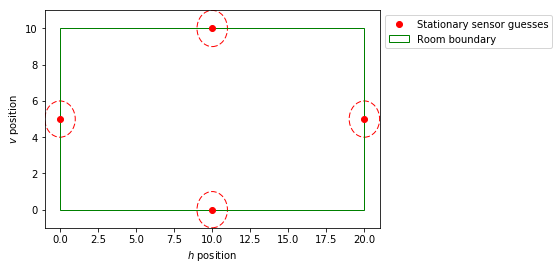

In [20]:
plt.plot(stationary_sensor_position_guesses[:,0],
         stationary_sensor_position_guesses[:,1],
         'ro',
        label='Stationary sensor guesses')
ax = plt.gca()
for stationary_sensor_index in range(num_stationary_sensors):
    ax.add_patch(patches.Ellipse((stationary_sensor_position_guesses[stationary_sensor_index,0],
                                  stationary_sensor_position_guesses[stationary_sensor_index,1]),
                                 width=stationary_sensor_position_guess_error*2,
                                 height=stationary_sensor_position_guess_error*2,
                                 fill=False,
                                 linestyle='dashed',
                                 color='red'))
ax.add_patch(patches.Rectangle((0,0),
                               room_size[0],
                               room_size[1],
                               fill=False,
                               color='green',
                               label='Room boundary'))
plt.xlabel('{} position'.format(dimension_names[0]))
plt.ylabel('{} position'.format(dimension_names[1]))
plt.xlim(0 - stationary_sensor_position_guess_error,
         room_size[0] + stationary_sensor_position_guess_error)
plt.ylim(0 - stationary_sensor_position_guess_error,
         room_size[1] + stationary_sensor_position_guess_error)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Define a function that generates samples of the initial state $\mathbf{X}_0$.

In [21]:
def x_initial_sample(num_samples=1):
    if num_moving_sensors > 0:
        moving_sensors = np.random.uniform(high=np.tile(room_size, num_moving_sensors),
                                           size=(num_samples, num_moving_sensors*len(room_size)))
    else:
        moving_sensors = np.array([])
    if num_stationary_sensors > 0:
        stationary_sensors = np.random.multivariate_normal(stationary_sensor_position_guesses.flatten(),
                                                           np.diagflat(np.repeat(stationary_sensor_position_guess_error**2,
                                                                                 num_stationary_sensors*num_dimensions)),
                                                           size=num_samples)
    else:
        stationary_sensors = np.array([])
    return np.squeeze(np.concatenate((moving_sensors, stationary_sensors), axis=1))

Generate 1,000 samples and check that they have the properties we expect.

In [22]:
time_start = time.clock()
x_initial_samples = x_initial_sample(1000)
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0204385958924


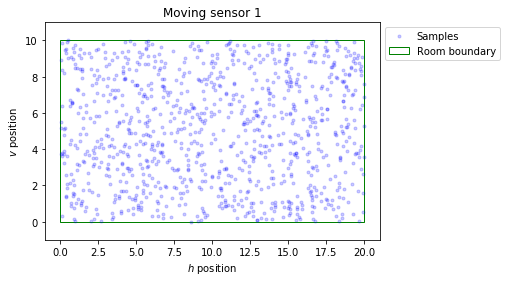

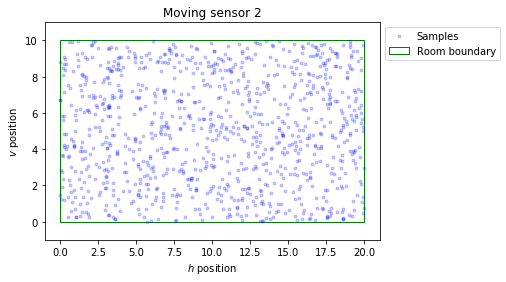

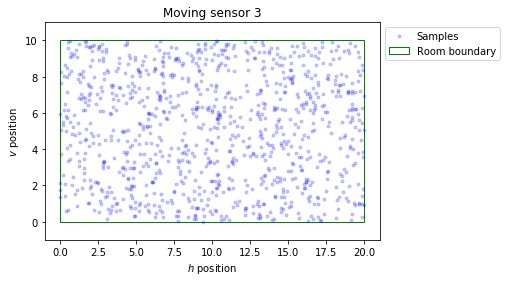

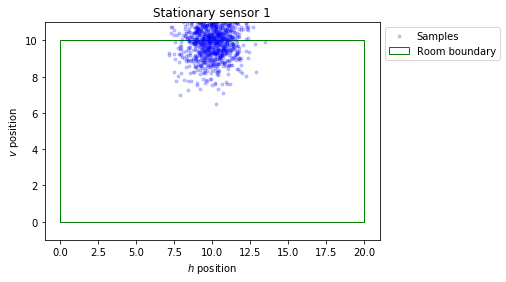

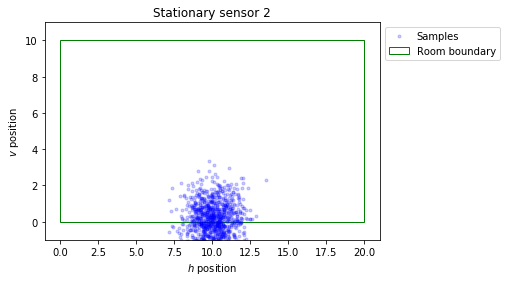

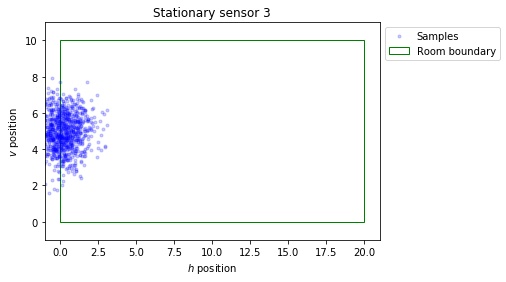

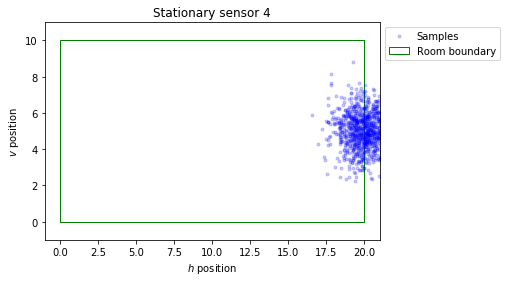

In [23]:
for sensor_index in range(num_sensors):
    plt.plot(x_initial_samples[:,sensor_index*2],
             x_initial_samples[:,sensor_index*2 + 1],
             'b.',
             alpha = 0.2,
             label="Samples")
    plt.title(sensor_names[sensor_index])
    plt.xlabel('{} position'.format(dimension_names[0]))
    plt.ylabel('{} position'.format(dimension_names[1]))
    ax=plt.gca()
    ax.add_patch(patches.Rectangle((0,0),
                                   room_size[0],
                                   room_size[1],
                                   fill=False,
                                   color='green',
                                   label='Room boundary'))
    plt.xlim(0 - stationary_sensor_position_guess_error,
             room_size[0] + stationary_sensor_position_guess_error)
    plt.ylim(0 - stationary_sensor_position_guess_error,
             room_size[1] + stationary_sensor_position_guess_error)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Calculate the sample means of the initial positions.

In [24]:
np.mean(x_initial_samples, 0)

array([  9.96461344,   5.04039467,  10.09922487,   5.05616151,
         9.96345395,   5.12933105,   9.98730306,   9.99797805,
        10.0335663 ,   0.07794674,   0.02819244,   4.95120548,
        20.00039744,   5.01678527])

Compare with the known means of the distributions the samples were drawn from (noting that the mean of the uniform distribution from zero to $a$ is $\frac{a}{2}$).

In [25]:
np.concatenate((np.tile(room_size/2, num_moving_sensors),
                stationary_sensor_position_guesses.flatten()))

array([ 10.,   5.,  10.,   5.,  10.,   5.,  10.,  10.,  10.,   0.,   0.,
         5.,  20.,   5.])

Calculate the sample standard deviations of the initial positions.

In [26]:
np.std(x_initial_samples, 0)

array([ 5.76625836,  2.92788011,  5.8786083 ,  2.90644747,  5.67010894,
        2.94265988,  1.01035293,  0.97490082,  0.98262641,  0.99340221,
        1.03543943,  1.01727425,  1.01398699,  1.00216338])

Compare with the known standard deviations of the distribution that the samples were drawn from (noting that the standard deviation of the uniform distribution over an interval of size $a$ is $\frac{a}{\sqrt{12}}$).

In [27]:
np.concatenate((np.tile(room_size/math.sqrt(12), num_moving_sensors),
                np.repeat(stationary_sensor_position_guess_error, num_stationary_sensors*2)))

array([ 5.77350269,  2.88675135,  5.77350269,  2.88675135,  5.77350269,
        2.88675135,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ])

### Transition model

Define a function that generates samples of the state $\mathbf{X}_t$ given $\mathbf{X}_{t-1}$. We'll use this both to generate our simulated data and as an input to the particle filter. Moving sensors execute a simple 2-d random walk. Stationary sensors generate two samples, one from their initial position distribution and one from a Gaussian centered on their last position, and then average these samples. The latter is a hack to introduce some fluctuations to the positions of the stationary sensors while ensuring that they remain near their guesses. This jitter helps the particle filter converge.

Define the amount of drift from one timestep to the next (for both moving sensors and stationary sensors).

In [28]:
moving_sensor_drift = 0.5
stationary_sensor_drift = 0.25

Define a function that generates samples of $\mathbf{X}_t$, given $\mathbf{X}_{t-1}$.

In [29]:
def x_bar_x_prev_sample(x_prev):
    if num_moving_sensors > 0:
        x_prev_moving_sensors = x_prev[...,:num_moving_sensors*num_dimensions]
        moving_sensor_positions = np.random.normal(loc=x_prev_moving_sensors,
                                                   scale=moving_sensor_drift)
    else:
        moving_sensor_positions = np.array([])
    if num_stationary_sensors > 0:
        x_prev_stationary_sensors = x_prev[...,num_moving_sensors*num_dimensions:]
        position_guesses = np.random.normal(loc=np.tile(stationary_sensor_position_guesses.flatten(),
                                                        x_prev_stationary_sensors.shape[:-1] + (1,)),
                                            scale=stationary_sensor_position_guess_error)
        drifted_positions = np.random.normal(loc=x_prev_stationary_sensors,
                                             scale=stationary_sensor_drift)
        stationary_sensor_positions = (position_guesses + drifted_positions)/2
    else:
        stationary_sensor_positions = np.array([])
    return np.concatenate((moving_sensor_positions, stationary_sensor_positions), axis=-1)

Choose an arbitrary test value for $\mathbf{X}$, drawn from the initial distribution, that we can use to test the various functions.

In [30]:
test_x_value = x_initial_sample()

In [31]:
test_x_value

array([ 10.75720912,   7.64651622,   7.10063486,   1.06676889,
        12.5034974 ,   3.34614591,   9.60345619,   9.108775  ,
        10.29178293,  -0.04594398,  -0.23511118,   4.16536278,
        19.05318699,   4.30150272])

Generate 1,000 samples for $\mathbf{X}_t$ (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [32]:
time_start = time.clock()
x_bar_x_prev_samples = x_bar_x_prev_sample(np.tile(test_x_value,(1000,1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.00214271817155


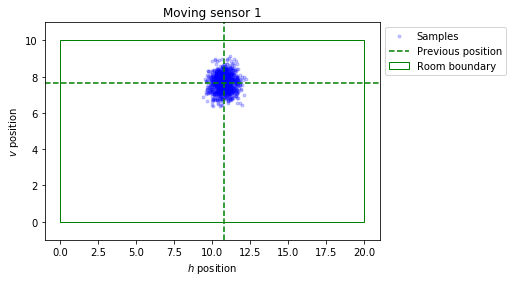

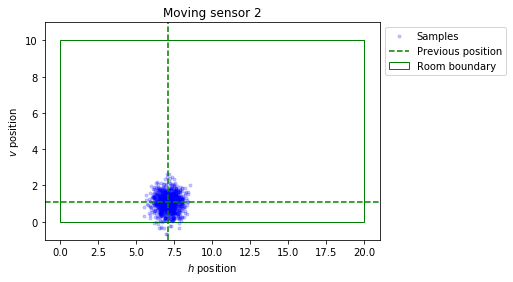

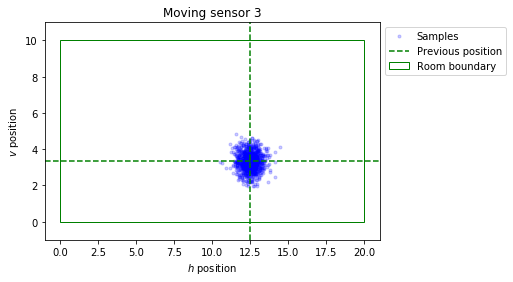

In [33]:
for sensor_index in range(num_moving_sensors):
    plt.plot(x_bar_x_prev_samples[:,sensor_index*2],
             x_bar_x_prev_samples[:,sensor_index*2 + 1],
             'b.',
             alpha=0.2,
            label='Samples')
    plt.title(sensor_names[sensor_index])
    plt.xlabel('{} position'.format(dimension_names[0]))
    plt.ylabel('{} position'.format(dimension_names[1]))
    plt.axvline(x=test_x_value[sensor_index*2],
                linestyle='dashed',
                color='green',
                label='Previous position')
    plt.axhline(y=test_x_value[sensor_index*2 + 1], linestyle='dashed', color='green')
    ax=plt.gca()
    ax.add_patch(patches.Rectangle((0,0),
                                   room_size[0],
                                   room_size[1],
                                   fill=False,
                                   color='green',
                                   label='Room boundary'))
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(0 - stationary_sensor_position_guess_error,
             room_size[0] + stationary_sensor_position_guess_error)
    plt.ylim(0 - stationary_sensor_position_guess_error,
             room_size[1] + stationary_sensor_position_guess_error)
    plt.show()

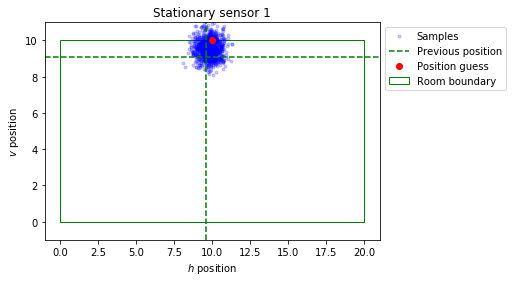

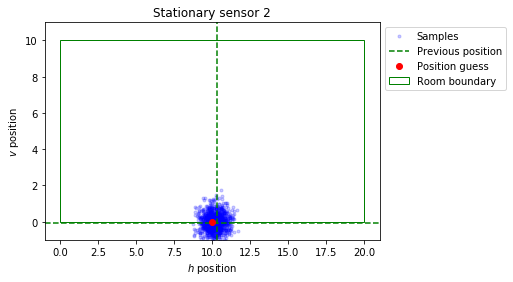

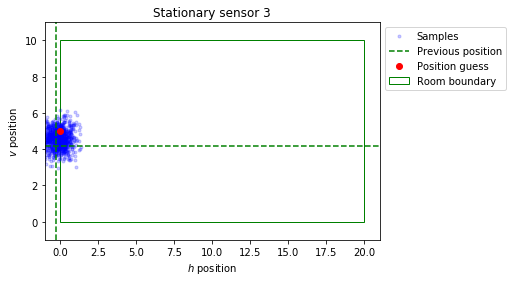

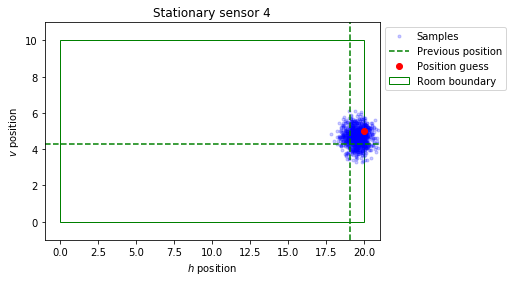

In [34]:
for sensor_index in range(num_moving_sensors, num_sensors):
    plt.plot(x_bar_x_prev_samples[:,sensor_index*2],
             x_bar_x_prev_samples[:,sensor_index*2 + 1],
             'b.',
             alpha=0.2,
             label='Samples')
    plt.title(sensor_names[sensor_index])
    plt.xlabel('{} position'.format(dimension_names[0]))
    plt.ylabel('{} position'.format(dimension_names[1]))
    plt.axvline(x=test_x_value[sensor_index*2], linestyle='dashed', color='green', label='Previous position')
    plt.axhline(y=test_x_value[sensor_index*2 + 1], linestyle='dashed', color='green')
    plt.plot(stationary_sensor_position_guesses[sensor_index-num_moving_sensors][0],
            stationary_sensor_position_guesses[sensor_index-num_moving_sensors][1],
            'ro',
            label = 'Position guess')
    ax=plt.gca()
    ax.add_patch(patches.Rectangle((0,0),
                                   room_size[0],
                                   room_size[1],
                                   fill=False,
                                   color='green',
                                   label='Room boundary'))
    plt.xlim(0 - stationary_sensor_position_guess_error,
             room_size[0] + stationary_sensor_position_guess_error)
    plt.ylim(0 - stationary_sensor_position_guess_error,
             room_size[1] + stationary_sensor_position_guess_error)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

### Sensor response model

We need the sensor response model in two forms. To generate the simulated data, we need functions that generate samples of the sensor readings $\mathbf{Y}$ given the underlying state of the system $\mathbf{X}$. For the particle filter, we need functions that give us the probability density at any given value of $\mathbf{Y}$, given $\mathbf{X}$.

#### Produce samples of $\mathbf{Y}$ given $\mathbf{X}$

First, define a function that returns the pairwise distances between the different sensors (in the same order as `y_names` above) given $\mathbf{X}$.

In [35]:
def distances(x):
    if x.ndim == 1:
        x = np.expand_dims(x, 0)
    num_x_values = x.shape[0]
    return np.squeeze(np.delete(np.linalg.norm(np.subtract(np.tile(x.reshape((num_x_values, num_sensors, num_dimensions)),
                                                                   (1, num_sensors, 1)),
                                                           np.repeat(x.reshape((num_x_values, num_sensors, num_dimensions)),
                                                                     num_sensors,
                                                                     axis = 1)),
                                               axis=2),
                                np.arange(num_sensors)*num_sensors + np.arange(num_sensors),1))

For the sensors variables that measure the status of the pings, we model the likelihood of receiving the ping as declining exponentially with distance. This roughly mirrors what we see in our real test data. First, we define a function that returns the probability of the two ping statuses (received or not received), given the distance between two sensors.

In [36]:
receive_probability_zero_distance = 1.0 # Value from real data is approximately 1.0
receive_probability_reference_distance = 0.7 #Value from real data is approximately 0.7
reference_distance = 20.0 # Value from real data is approximately 20.0
scale_factor = reference_distance/np.log(receive_probability_reference_distance/receive_probability_zero_distance)

In [37]:
def ping_status_probabilities(distance):
    receive_probability=receive_probability_zero_distance*np.exp(distance/scale_factor)
    return np.stack((receive_probability, 1 - receive_probability), axis=0)

Plot this function to make sure it has the properties we expect.

In [38]:
distance_range_min = 0.5
distance_range_max = 2*np.linalg.norm(room_size)

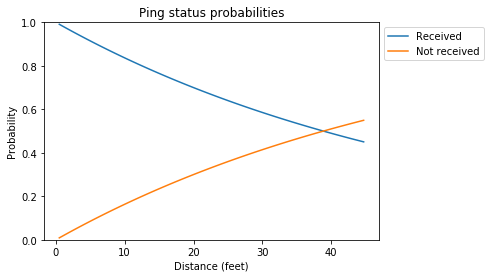

In [39]:
distance_range = np.linspace(distance_range_min, distance_range_max, 100)
ping_status_probabilities_range = ping_status_probabilities(distance_range)
for ping_status_index in range(num_ping_statuses):
    plt.plot(distance_range,
             ping_status_probabilities_range[ping_status_index, :],
             label=ping_status_names[ping_status_index])
plt.ylim(0,1)
plt.xlabel('Distance (feet)')
plt.ylabel('Probability')
plt.title('Ping status probabilities')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Using this function, define a function that returns samples of the discrete $\mathbf{Y}$ variables (the status of all of the pings), given a value of $\mathbf{X}$ (the positions of all of the sensors).

In [40]:
def y_discrete_bar_x_sample(x):
    return np.apply_along_axis(lambda p_array: np.random.choice(len(p_array), p=p_array),
                               axis=0,
                               arr=ping_status_probabilities(distances(x)))

Generate 1,000 samples (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [41]:
time_start = time.clock()
y_discrete_bar_x_samples = y_discrete_bar_x_sample(np.tile(test_x_value, (1000,1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 1.15966962375


In [42]:
distances_test_x_value = distances(test_x_value)

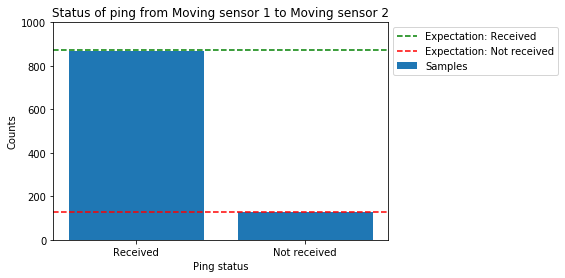

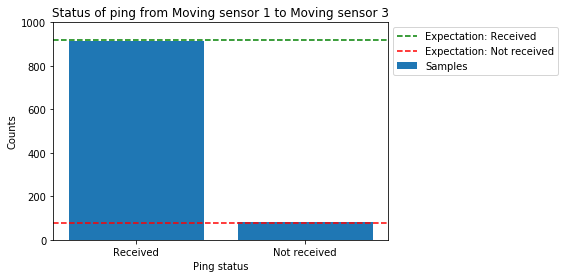

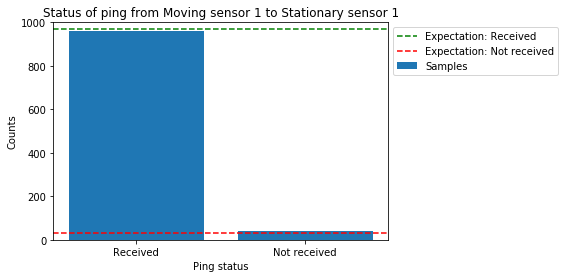

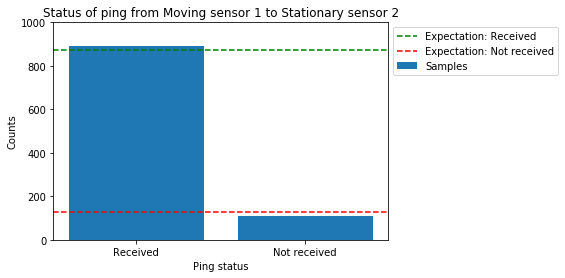

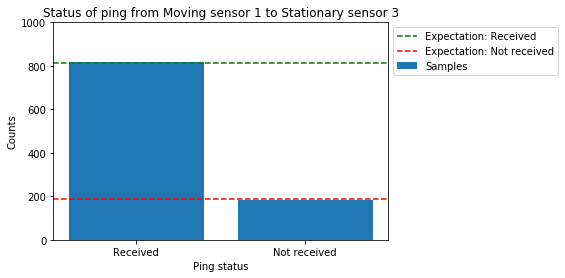

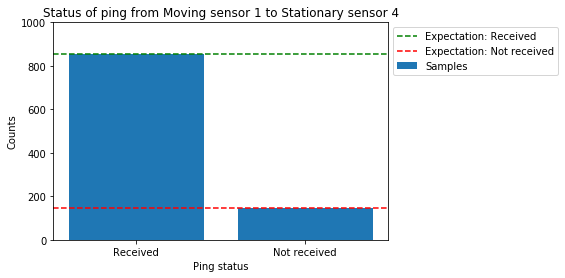

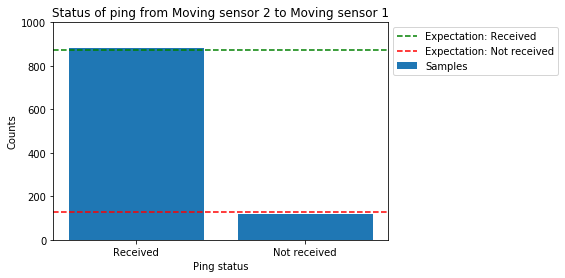

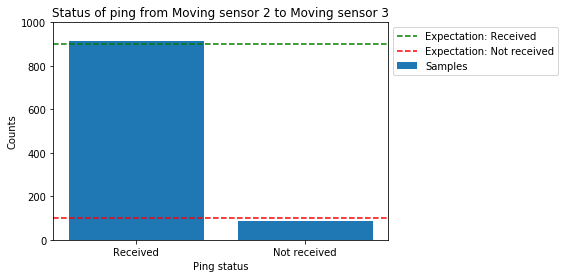

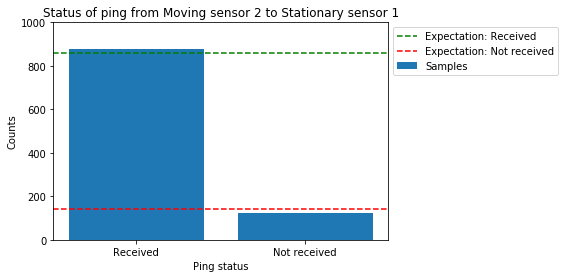

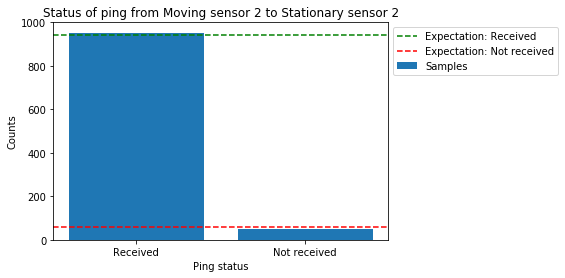

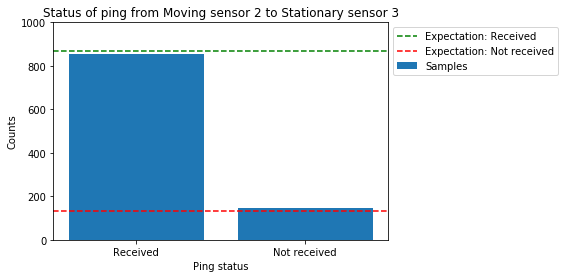

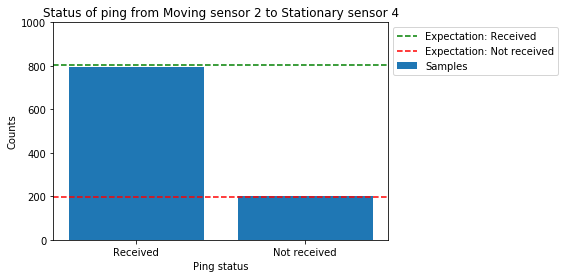

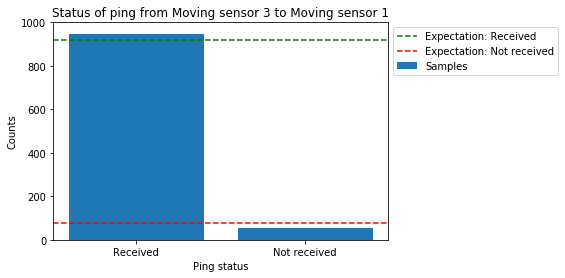

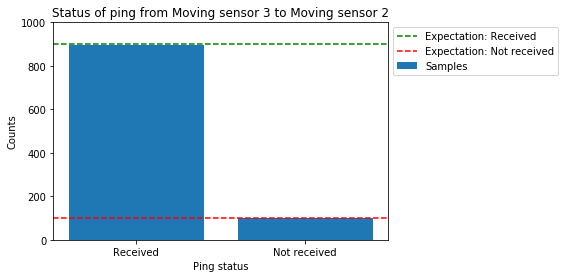

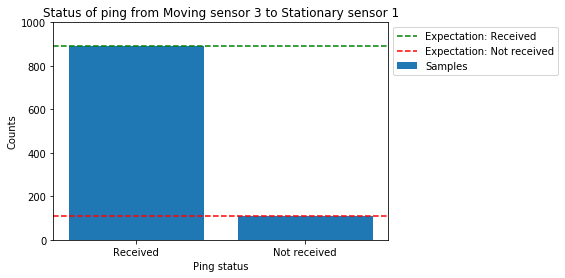

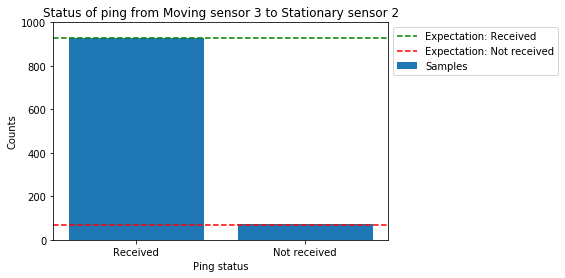

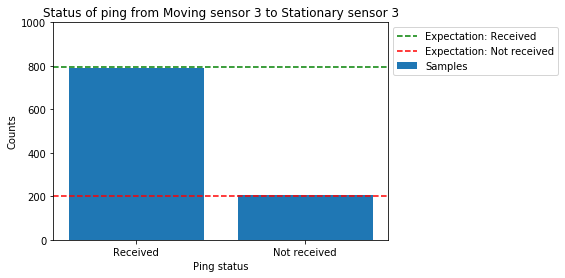

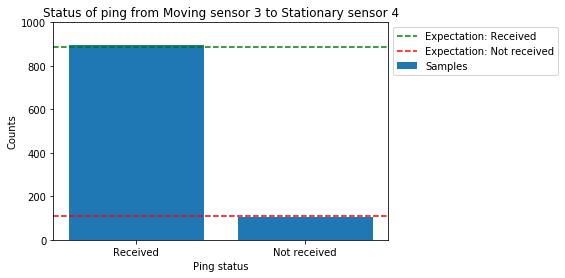

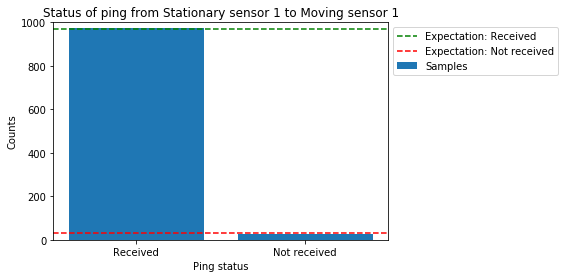

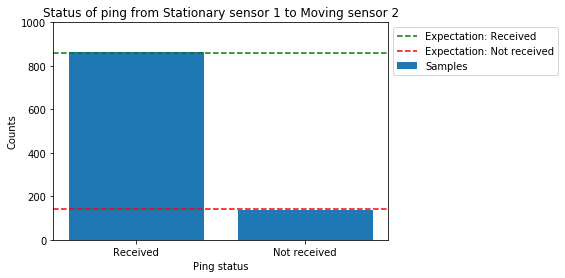

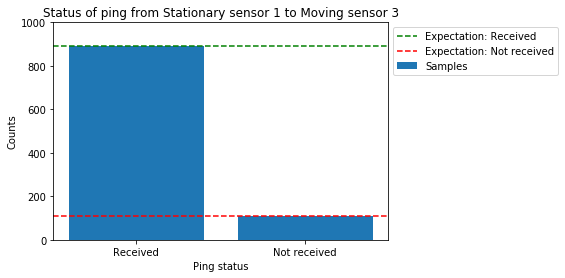

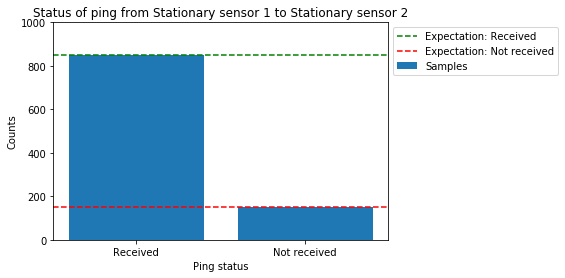

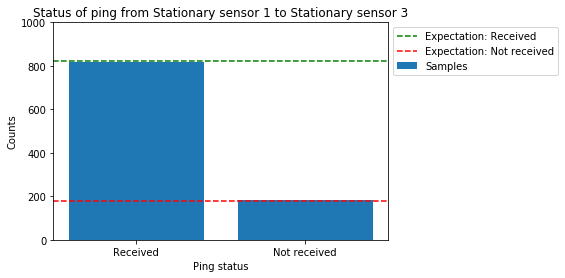

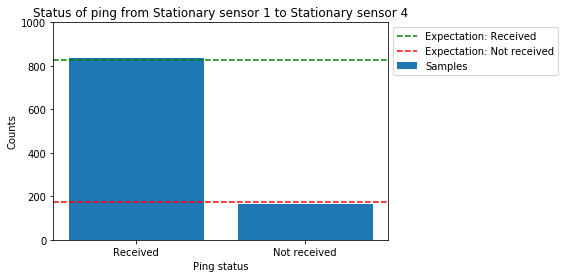

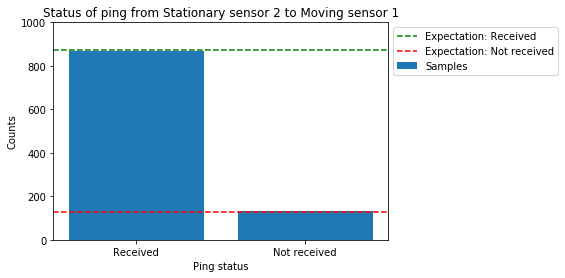

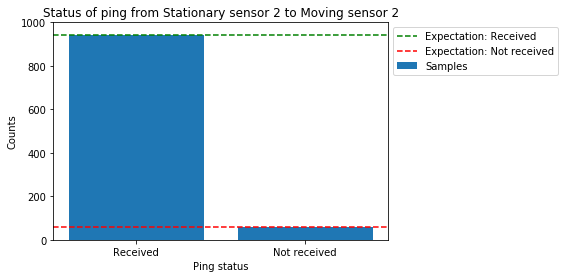

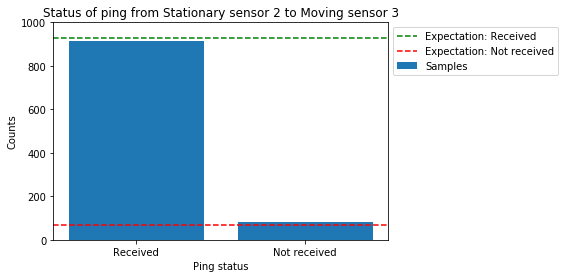

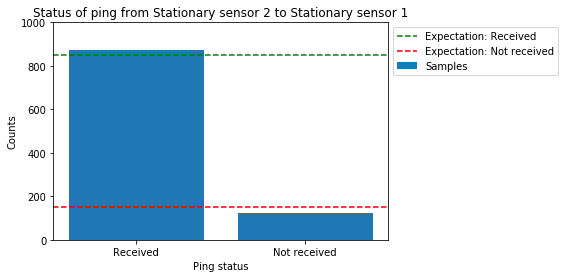

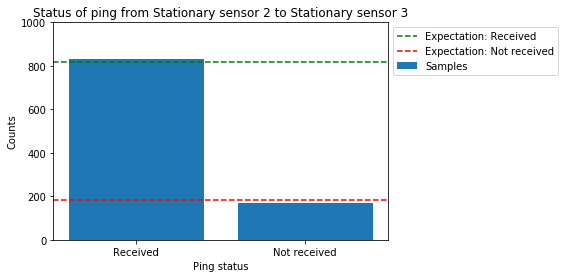

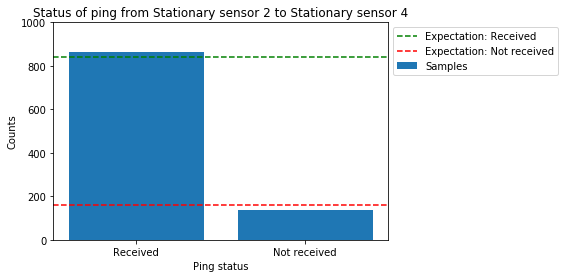

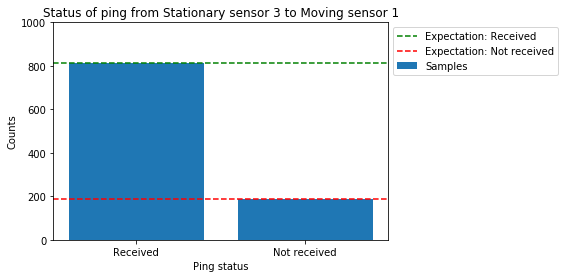

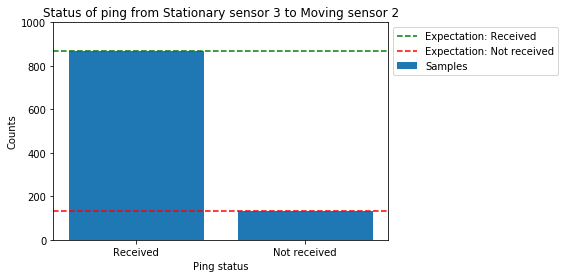

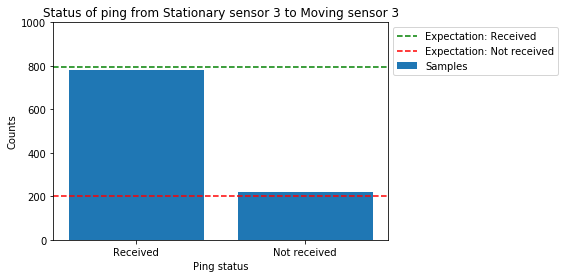

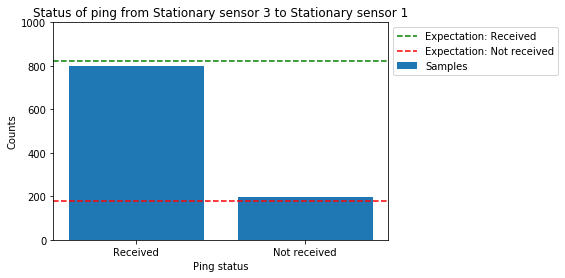

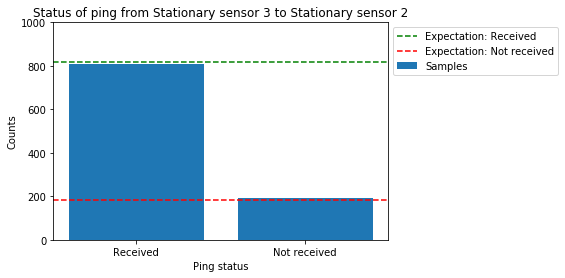

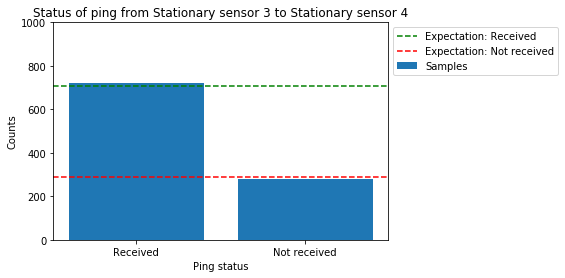

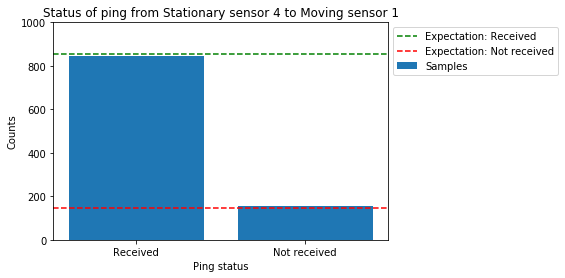

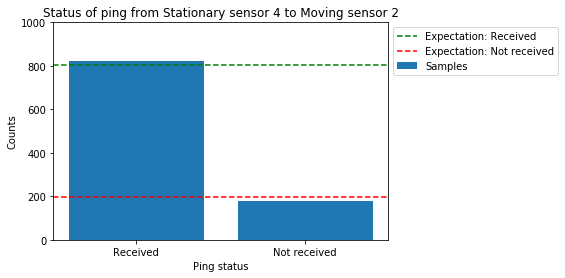

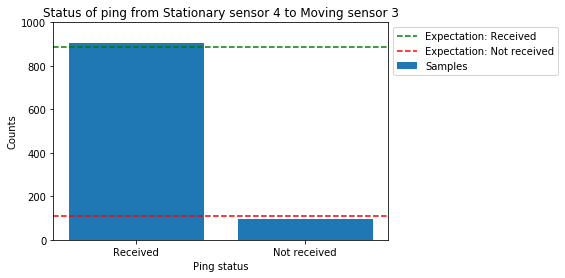

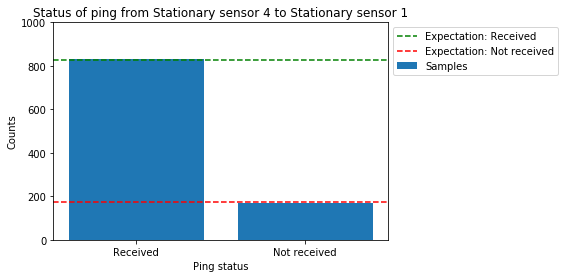

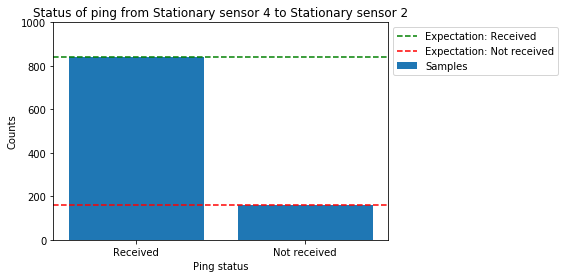

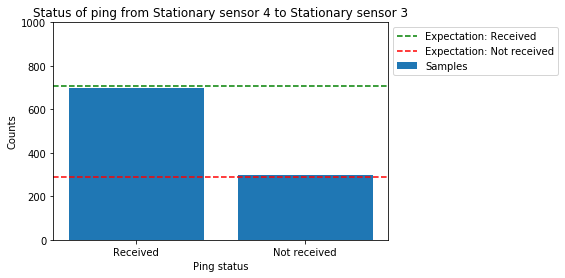

In [43]:
for y_discrete_var_index in range(num_y_discrete_vars):
    plt.bar(range(num_ping_statuses), np.bincount(y_discrete_bar_x_samples[:,y_discrete_var_index]), label='Samples')
    for ping_status_index in range(num_ping_statuses):
        plt.axhline(y=ping_status_probabilities(distances_test_x_value[y_discrete_var_index])[ping_status_index]*1000,
                    linestyle='dashed',
                    color=['green', 'red'][ping_status_index],
                    label='Expectation: {}'.format(ping_status_names[ping_status_index]))
    plt.xticks(range(num_ping_statuses), ping_status_names)
    plt.xlabel('Ping status')
    plt.ylabel('Counts')
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.ylim(0, 1000)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For the sensor variables that measure the RSSI of the received pings, we model the measured RSSI as a Gaussian with a mean that drops off linearly in the log of the distance with a slope of -20 (i.e., $1/d^2$ fall-off), a large amount of noise, and a hard lower cut-off at -82 dB. This roughly mirrors what we see in the real test data. First, we define functions that return the means of the truncated and untruncated distributions, given the distance between the sensors.

In [44]:
rssi_untruncated_mean_intercept = -64.0 # Value for real data is approximately -64.0
rssi_untruncated_mean_slope = -20.0 # Value for real data is approximately -20.0
rssi_untruncated_std_dev = 9.0 # Value for real data is approximately 9.0
lower_rssi_cutoff = -82.0 # Value for real data is approximately -82.0

In [45]:
def rssi_untruncated_mean(distance):
    return rssi_untruncated_mean_intercept + rssi_untruncated_mean_slope*np.log10(distance)

In [46]:
def rssi_truncated_mean(distance):
    return stats.truncnorm.stats(a=(lower_rssi_cutoff - rssi_untruncated_mean(distance))/rssi_untruncated_std_dev,
                                 b=np.inf,
                                 loc=rssi_untruncated_mean(distance),
                                 scale=rssi_untruncated_std_dev,
                                 moments='m')

Plot these functions to make sure they have the properties we expect.

In [47]:
rssi_range_min = rssi_untruncated_mean(distance_range_max)
rssi_range_max = rssi_untruncated_mean(distance_range_min)

c:\python27\lib\site-packages\scipy\stats\_continuous_distns.py:4870: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


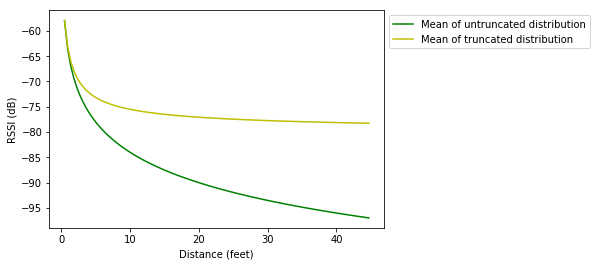

In [48]:
distance_range = np.linspace(distance_range_min, distance_range_max, 100)
plt.plot(distance_range,
         rssi_untruncated_mean(distance_range),
         'g-',
         label='Mean of untruncated distribution')
plt.plot(distance_range,
         rssi_truncated_mean(distance_range),
         'y-',
         label='Mean of truncated distribution')
plt.xlabel('Distance (feet)')
plt.ylabel('RSSI (dB)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Using these functions, define a function that returns a sample of an RSSI measurement, given the distance between two sensors.

In [49]:
def rssi_sample(distance):
    return stats.truncnorm.rvs(a=(lower_rssi_cutoff - rssi_untruncated_mean(distance))/rssi_untruncated_std_dev,
                               b=np.inf,
                               loc=rssi_untruncated_mean(distance),
                               scale=rssi_untruncated_std_dev)

Using this function, define a function that returns a sample of all of the RSSI readings, given all of the sensor positions.

In [50]:
def y_continuous_bar_x_sample(x):
    return rssi_sample(distances(x))

Generate 1,000 samples (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [51]:
time_start = time.clock()
y_continuous_bar_x_samples = y_continuous_bar_x_sample(np.tile(test_x_value, (1000, 1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0184925708863


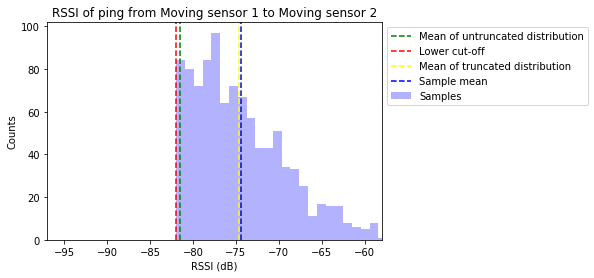

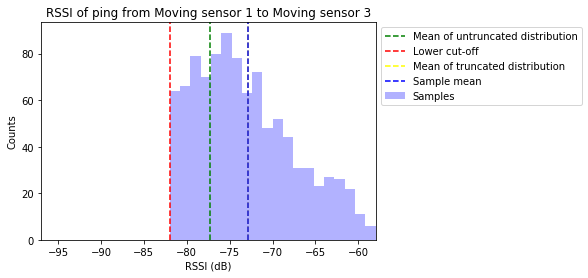

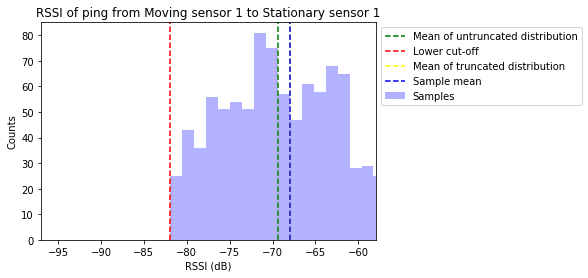

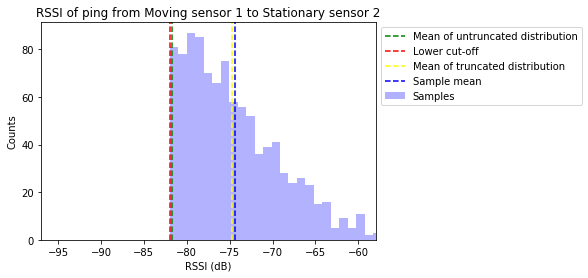

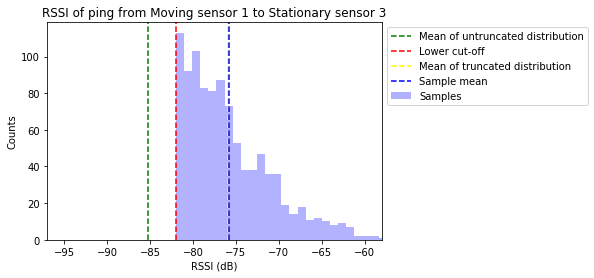

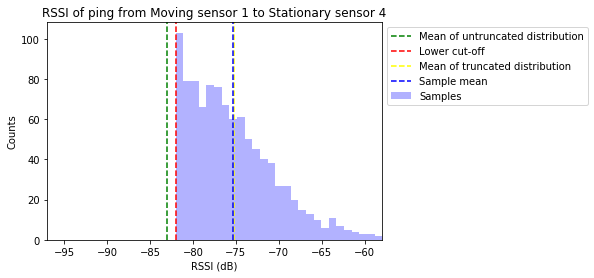

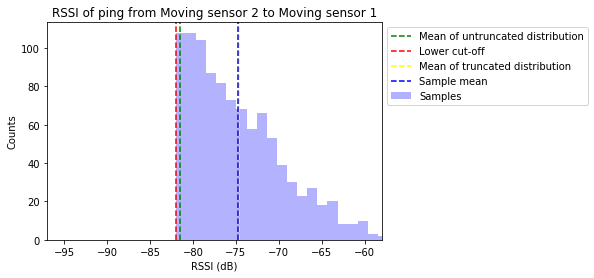

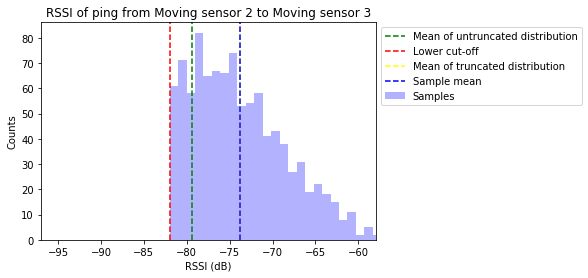

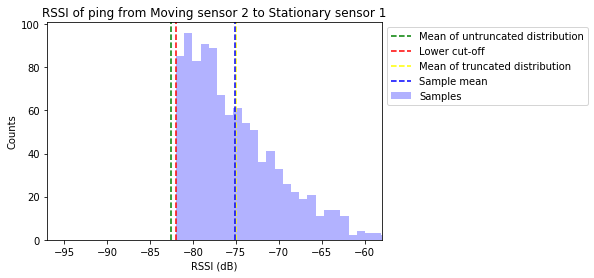

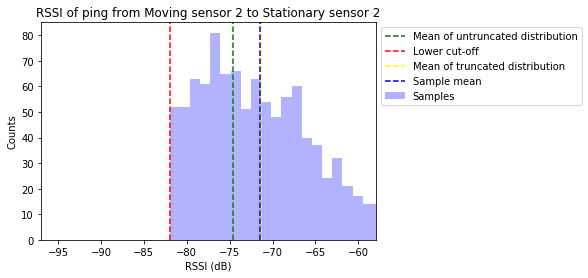

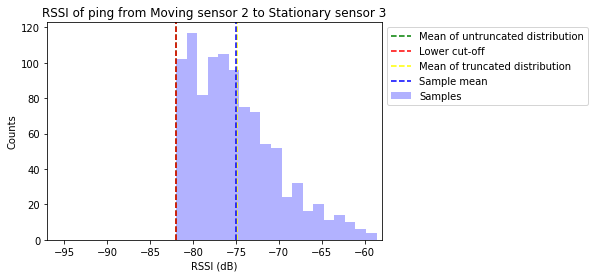

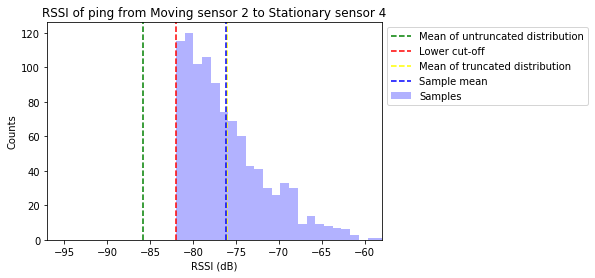

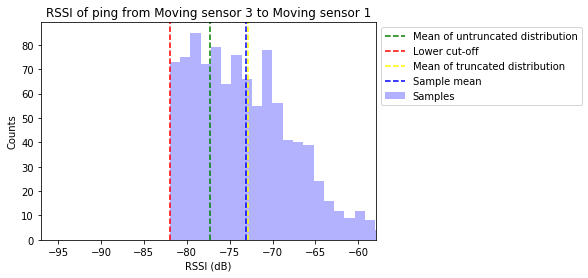

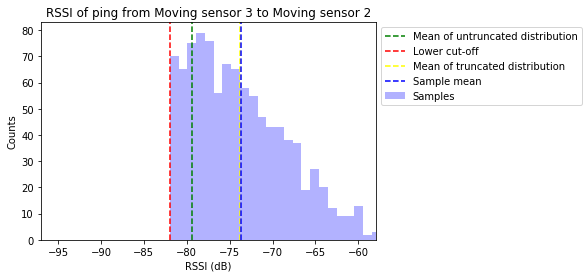

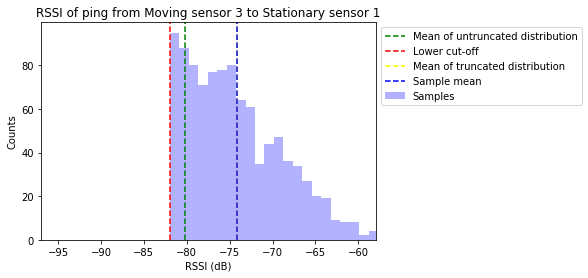

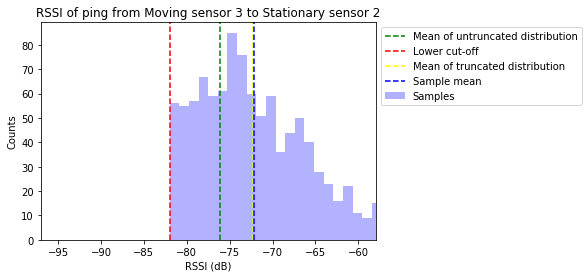

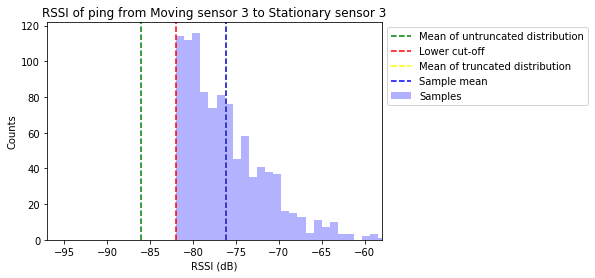

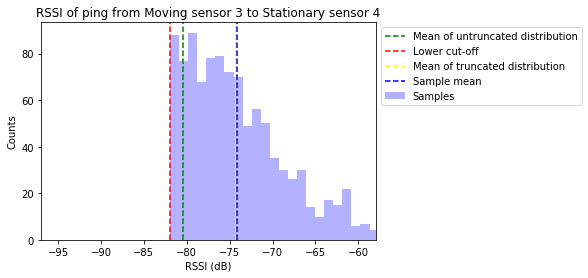

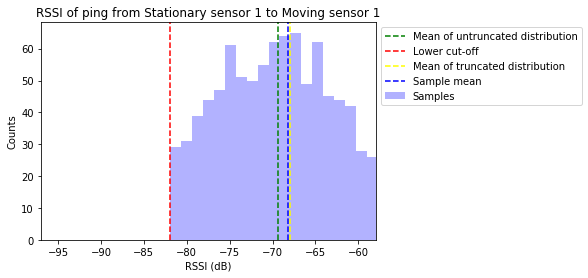

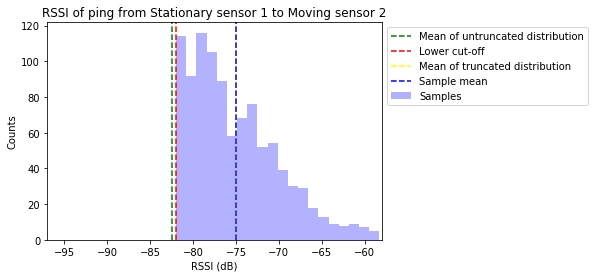

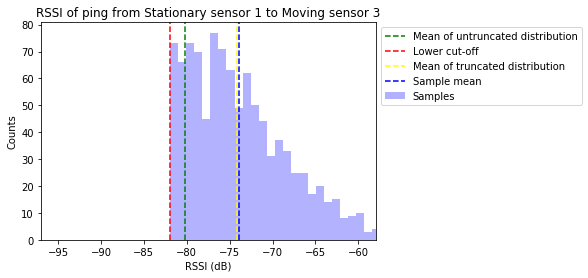

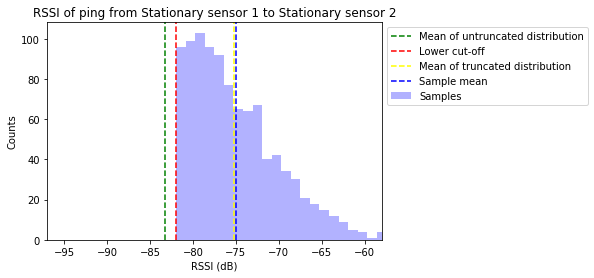

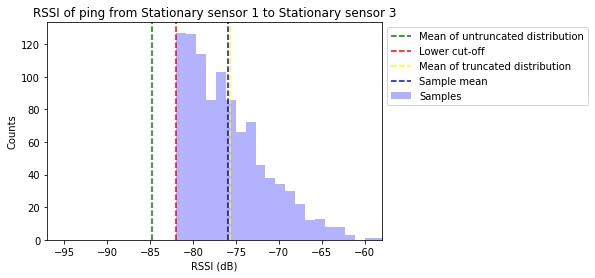

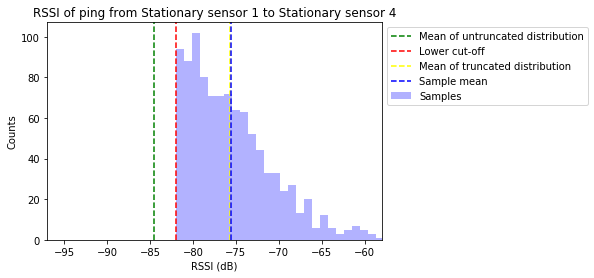

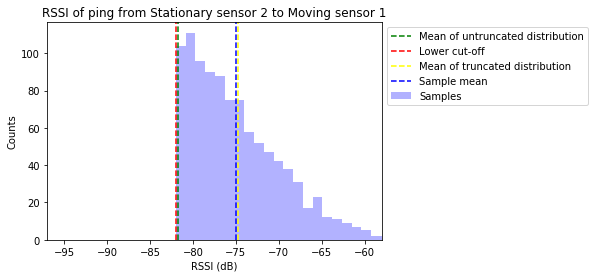

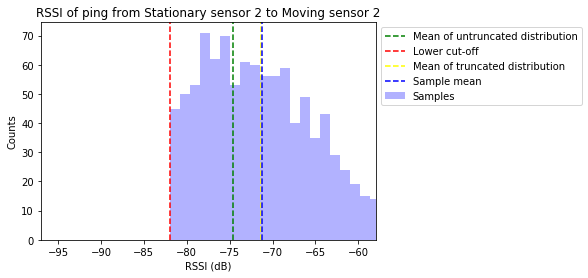

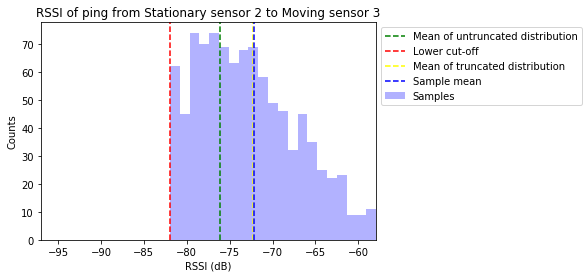

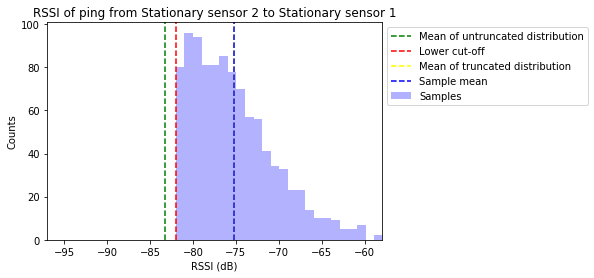

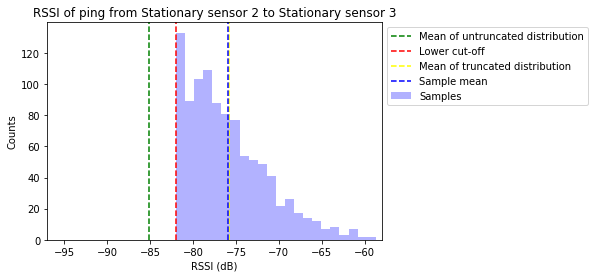

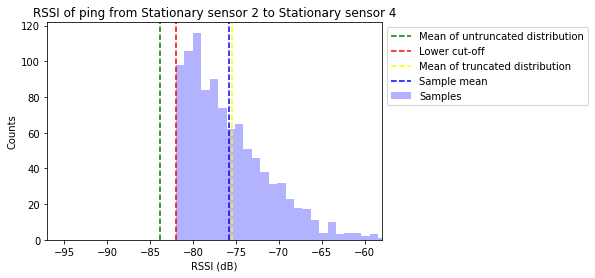

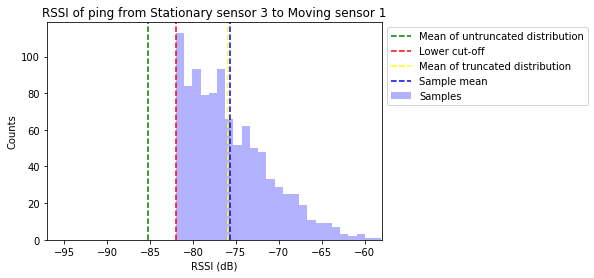

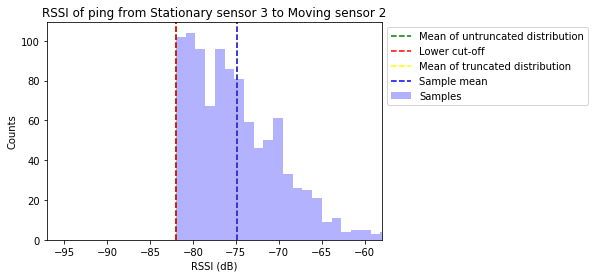

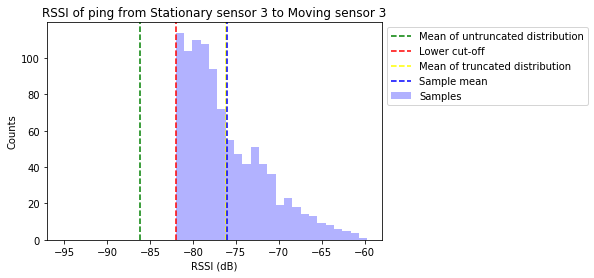

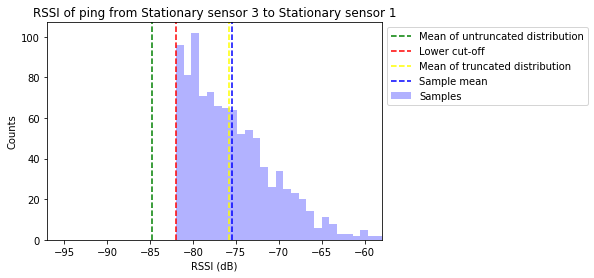

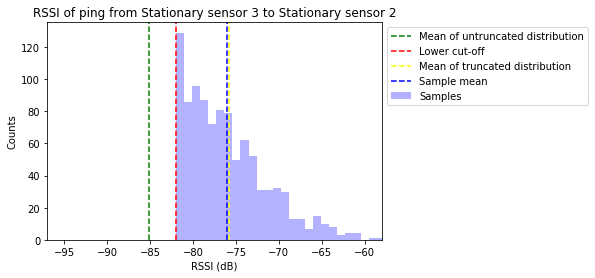

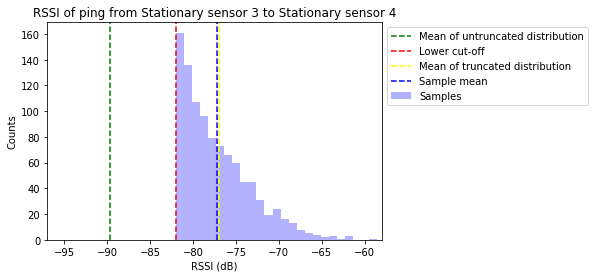

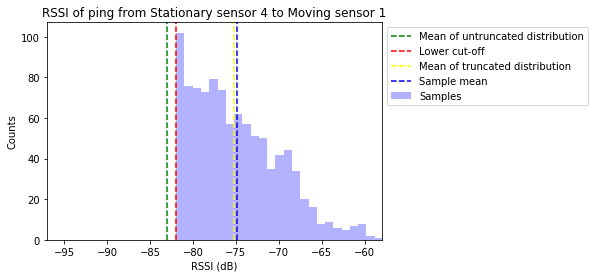

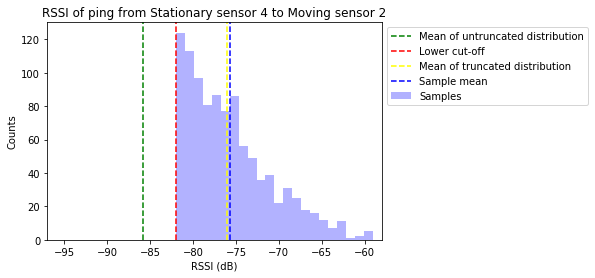

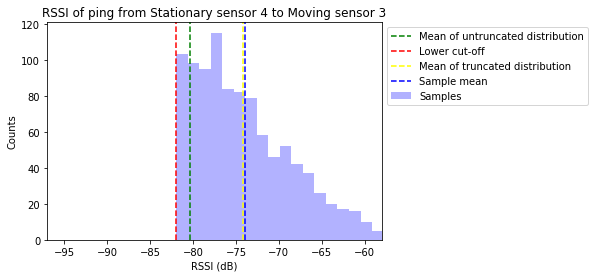

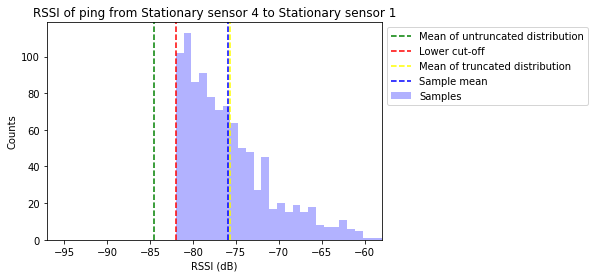

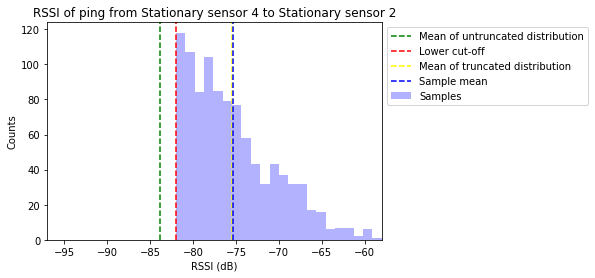

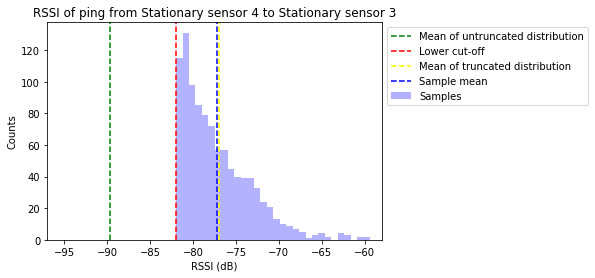

In [52]:
for y_continuous_var_index in range(num_y_continuous_vars):
    plt.hist(y_continuous_bar_x_samples[:,y_continuous_var_index],
             bins=30,
             facecolor='blue',
             alpha=0.3,
             label='Samples')
    plt.axvline(x=rssi_untruncated_mean(distances_test_x_value[y_continuous_var_index]),
                linestyle='dashed',
                color='green',
                label='Mean of untruncated distribution')
    plt.axvline(lower_rssi_cutoff,
                linestyle='dashed',
                color='red',
                label='Lower cut-off')
    plt.axvline(x=rssi_truncated_mean(distances_test_x_value[y_continuous_var_index]),
                linestyle='dashed',
                color='yellow',
                label='Mean of truncated distribution')
    plt.axvline(np.mean(y_continuous_bar_x_samples[:,y_continuous_var_index]),
                linestyle='dashed',
                color='blue',
                label='Sample mean')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Counts')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(rssi_range_min, rssi_range_max)
    plt.show()

Calculate probability density of $\mathbf{Y}$ given $\mathbf{X}$

Define a function that returns the log of the probability density for a left truncated normal distribution (we define our own function because the corresponding `scipy` function has a bug in it).

In [53]:
def left_truncnorm_logpdf(x, untruncated_mean, untruncated_std_dev, left_cutoff):
    logf = np.array(np.subtract(stats.norm.logpdf(x, loc=untruncated_mean, scale=untruncated_std_dev),
                                np.log(1 - stats.norm.cdf(left_cutoff, loc=untruncated_mean, scale=untruncated_std_dev))))
    logf[x < left_cutoff] = -np.inf
    return logf

Using this function (and the various functions and variable defined above), define a function that returns the log of the probabilty density for a given value of all of the sensors variables (ping statuses and received RSSIs), given the values of all of the state variables (the positions of all of the sensors).

In [54]:
def log_f_y_bar_x(x, y_discrete, y_continuous):
    distances_x = distances(x)
    discrete_log_probabilities = np.log(np.choose(y_discrete,
                                                  ping_status_probabilities(distances_x)))
    continuous_log_probability_densities = left_truncnorm_logpdf(y_continuous,
                                                                 rssi_untruncated_mean(distances_x),
                                                                 rssi_untruncated_std_dev,
                                                                 lower_rssi_cutoff)
    continuous_log_probability_densities[y_discrete == 1] = 0.0
    return np.sum(discrete_log_probabilities, axis=-1) + np.sum(continuous_log_probability_densities, axis=-1)

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect. First we plot the dependence on the discrete sensor variables.

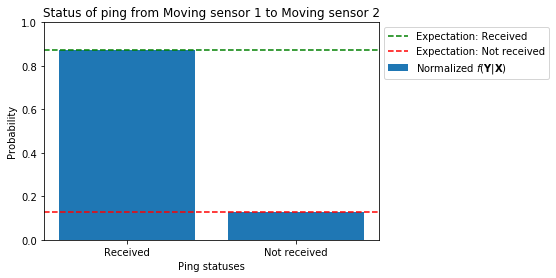

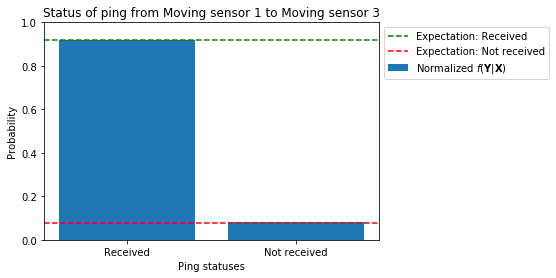

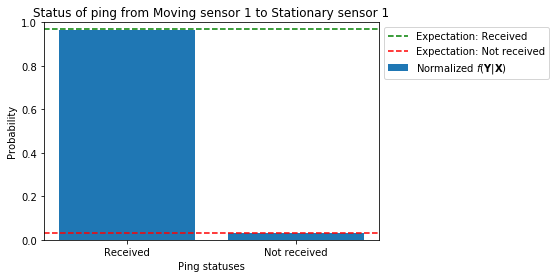

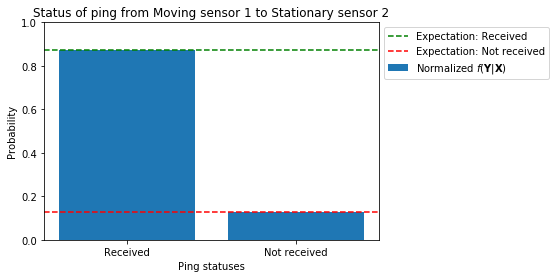

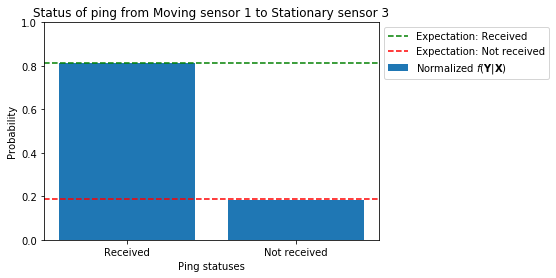

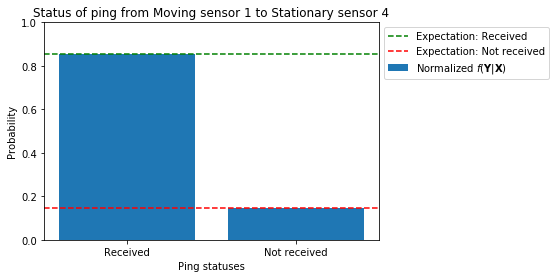

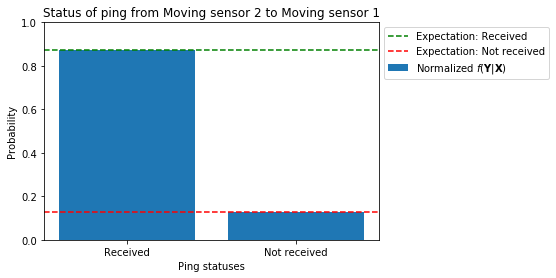

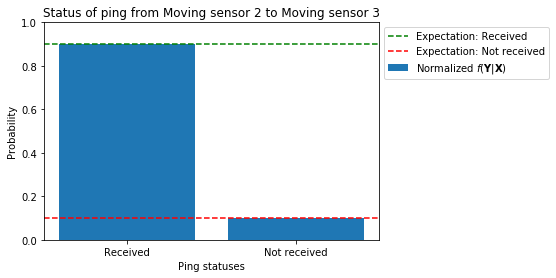

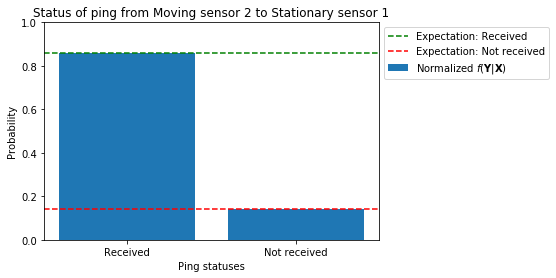

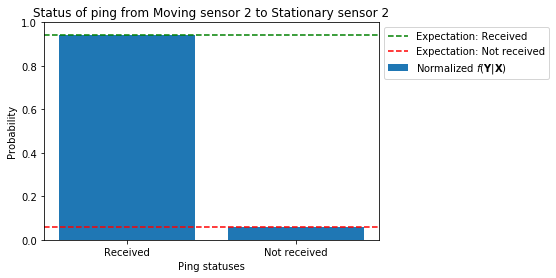

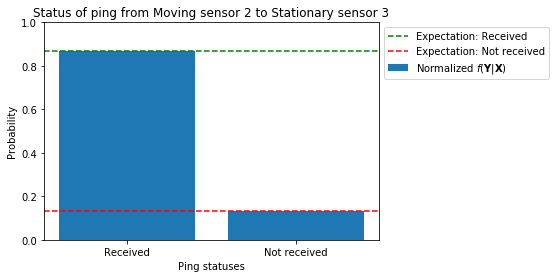

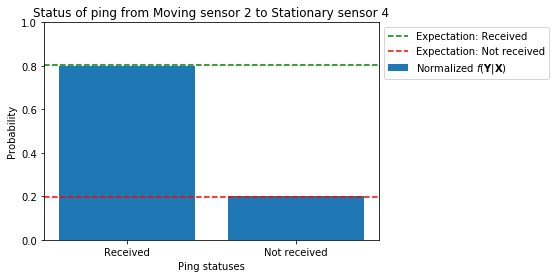

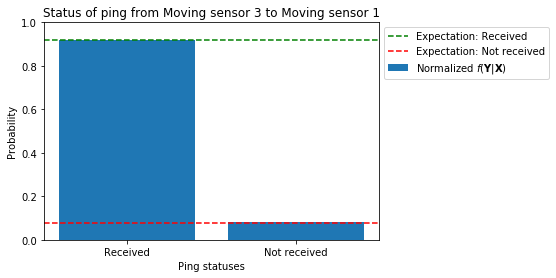

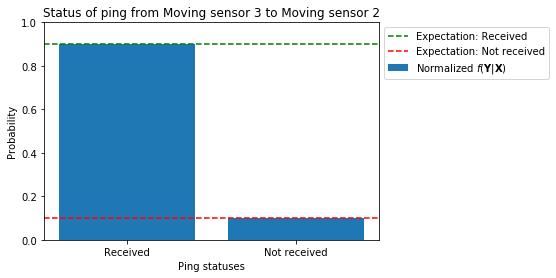

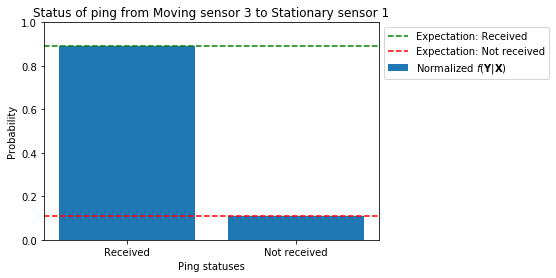

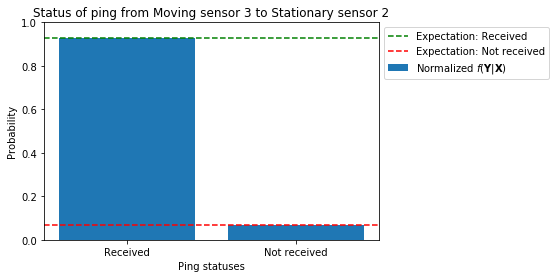

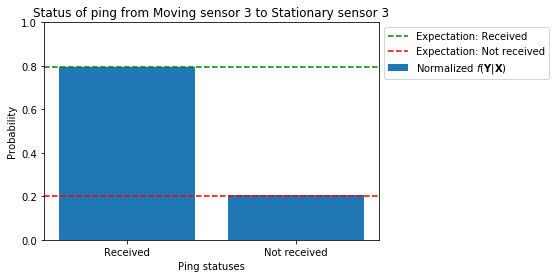

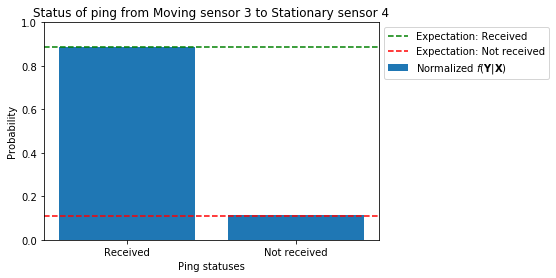

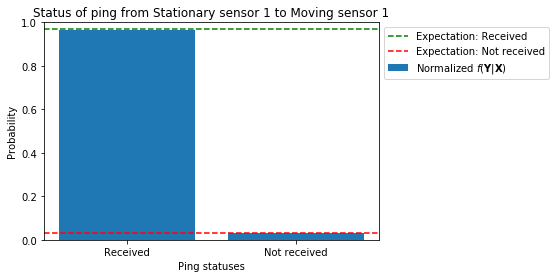

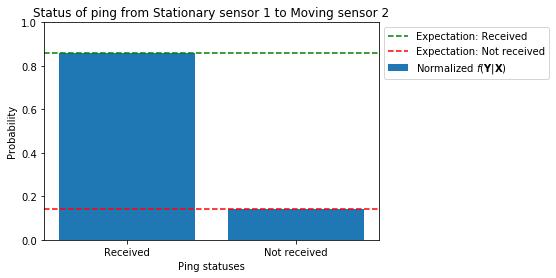

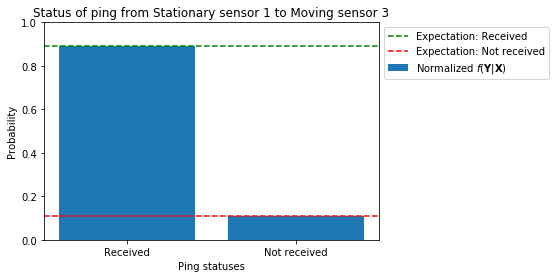

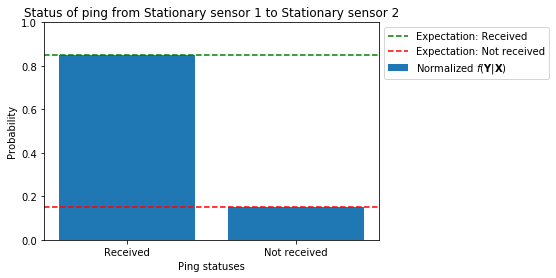

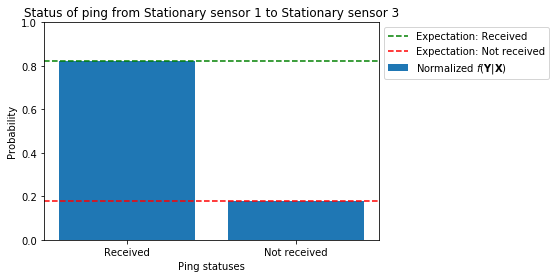

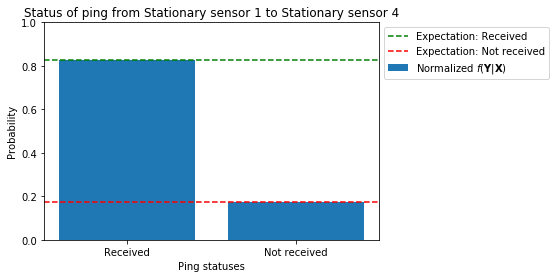

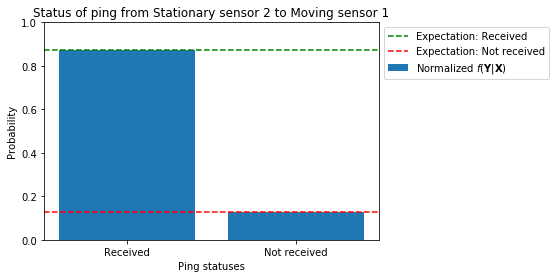

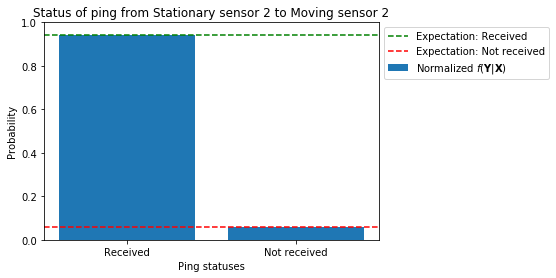

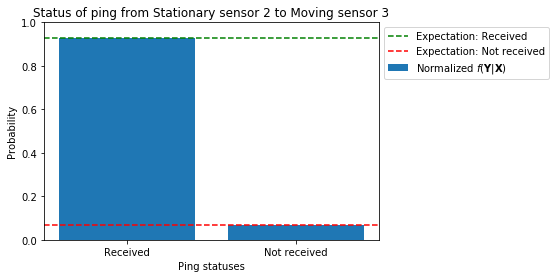

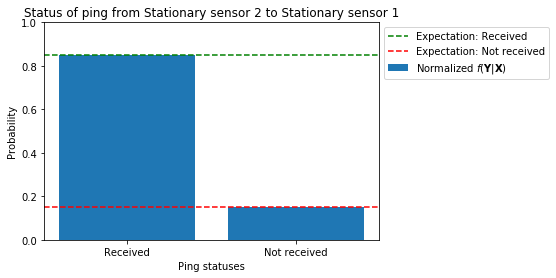

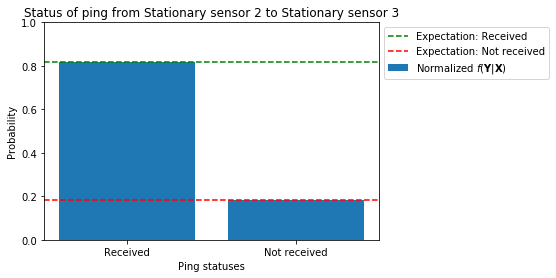

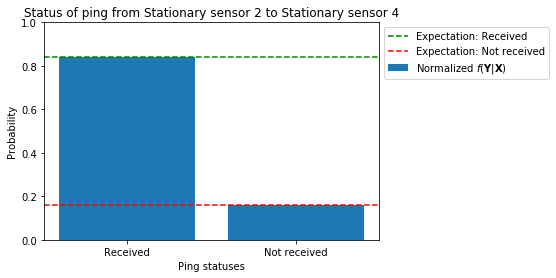

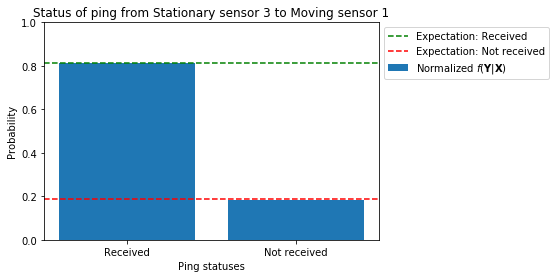

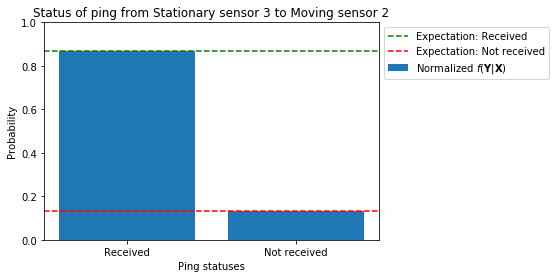

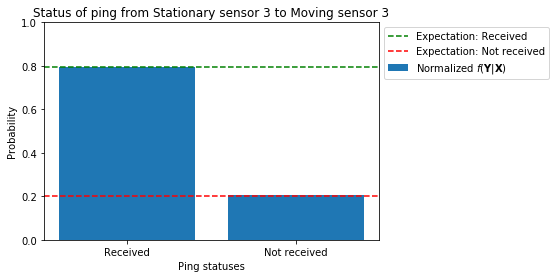

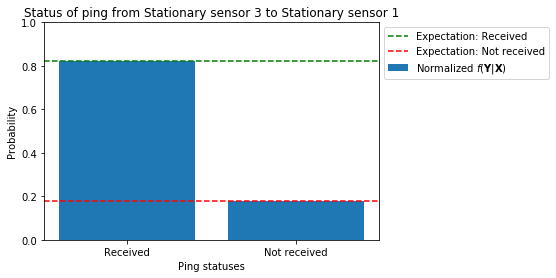

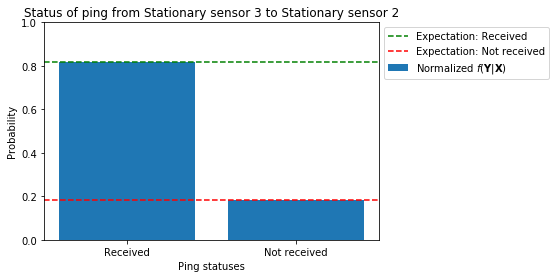

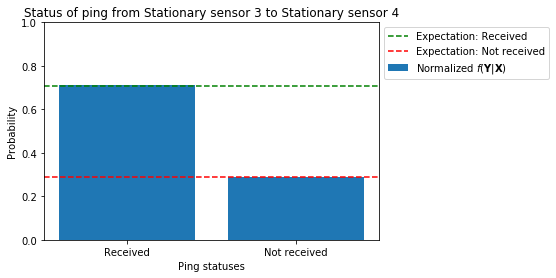

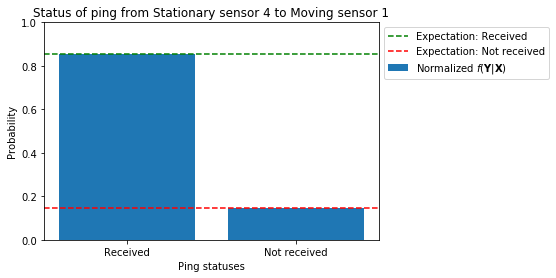

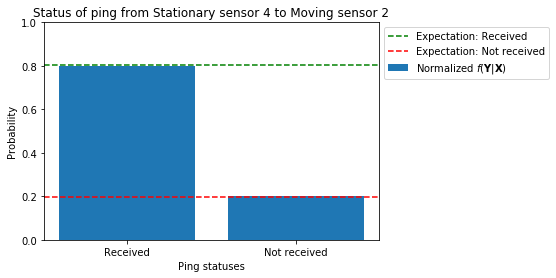

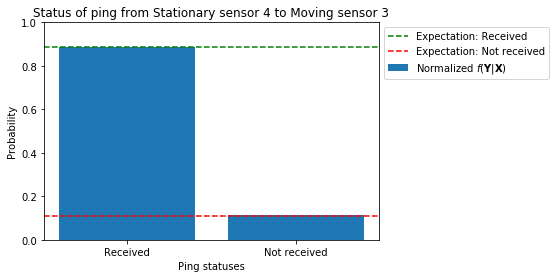

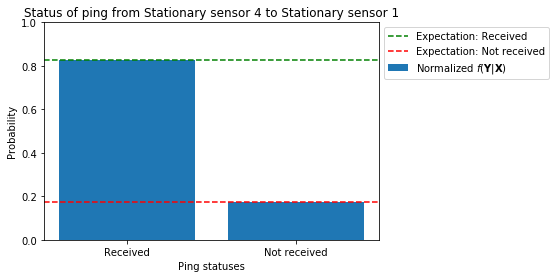

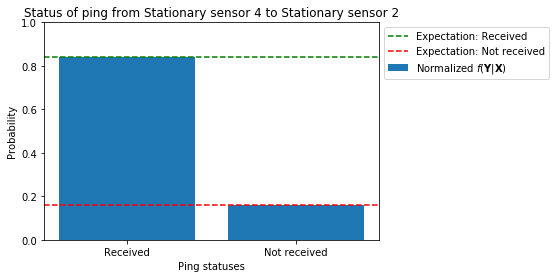

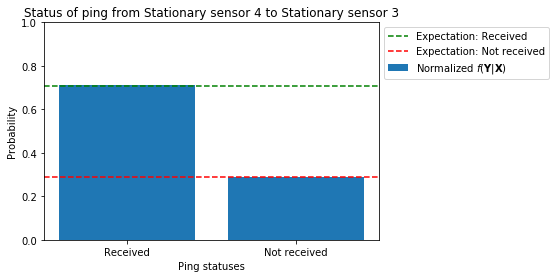

In [55]:
mean_rssi_values = rssi_truncated_mean(distances_test_x_value)
for y_discrete_var_index in range(num_y_discrete_vars):
    test_y_discrete_value = np.repeat(0, num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    probability_range = np.zeros(2, dtype='float')
    probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(mean_rssi_values[y_discrete_var_index] - 2*rssi_untruncated_std_dev,
                           mean_rssi_values[y_discrete_var_index] + 2*rssi_untruncated_std_dev,
                           100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_discrete_var_index] = rssi_range[rssi_index]
        probability_density_range[rssi_index] = math.exp(log_f_y_bar_x(test_x_value,
                                                                            test_y_discrete_value,
                                                                            test_y_continuous_value))
    probability_range[0] = np.sum(probability_density_range)*(rssi_range[1]-rssi_range[0])
    test_y_discrete_value[y_discrete_var_index] = 1
    test_y_continuous_value = mean_rssi_values
    probability_range[1] = math.exp(log_f_y_bar_x(test_x_value,
                                                  test_y_discrete_value,
                                                  test_y_continuous_value))
    probability_range = probability_range/np.sum(probability_range)
    plt.bar(range(num_ping_statuses),
            probability_range,
            label='Normalized $f(\mathbf{Y}|\mathbf{X})$')
    for ping_status_index in range(num_ping_statuses):
        plt.axhline(y=ping_status_probabilities(distances_test_x_value[y_discrete_var_index])[ping_status_index],
                    linestyle='dashed',
                    color=['green', 'red'][ping_status_index],
                    label='Expectation: {}'.format(ping_status_names[ping_status_index]))
    plt.xticks(range(num_ping_statuses), ping_status_names)
    plt.ylim(0,1)
    plt.xlabel('Ping statuses')
    plt.ylabel('Probability')
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Now we plot the dependence on the continuous sensor variables.

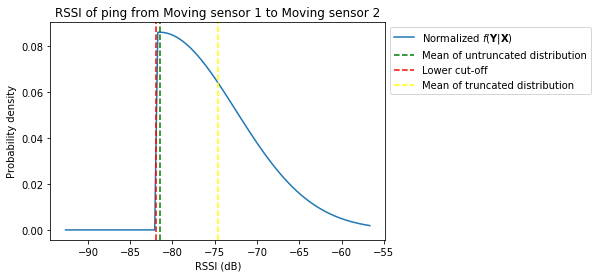

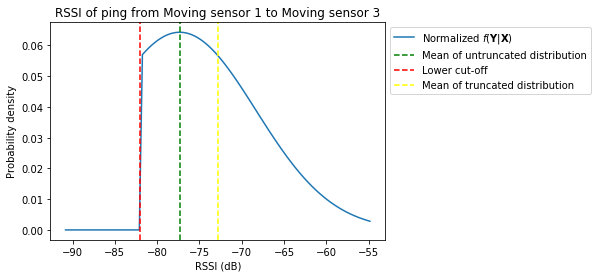

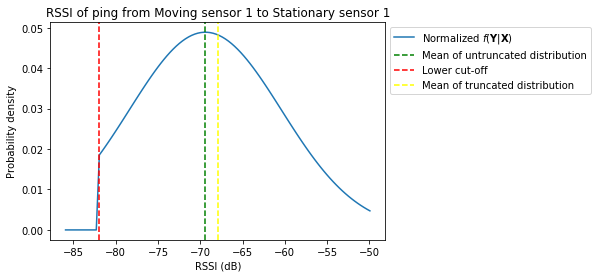

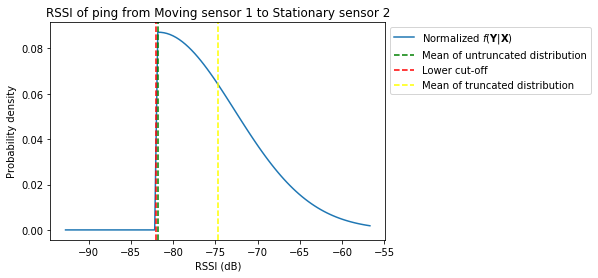

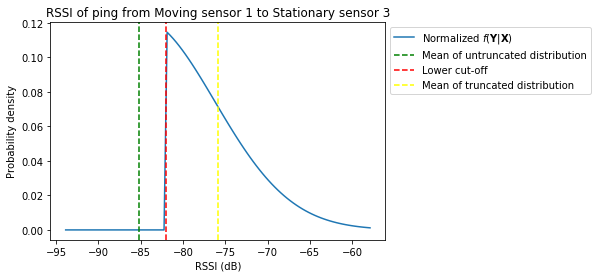

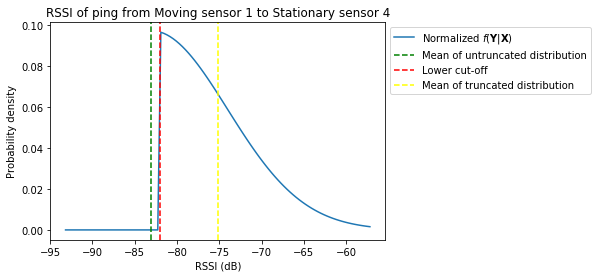

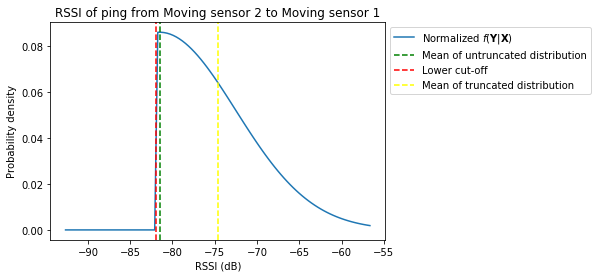

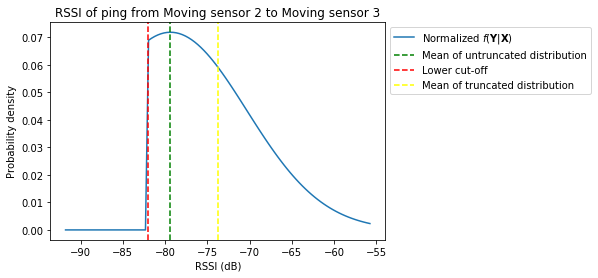

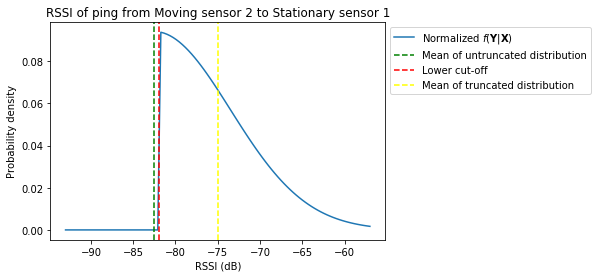

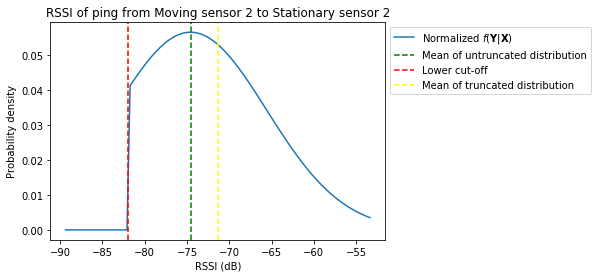

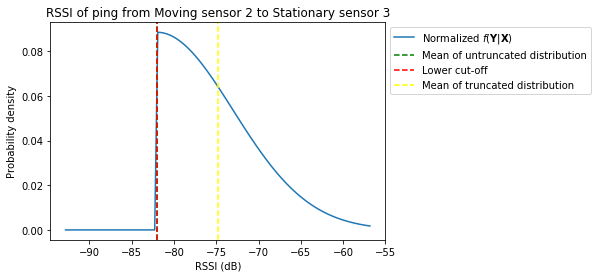

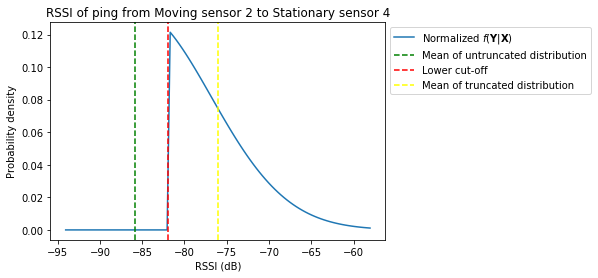

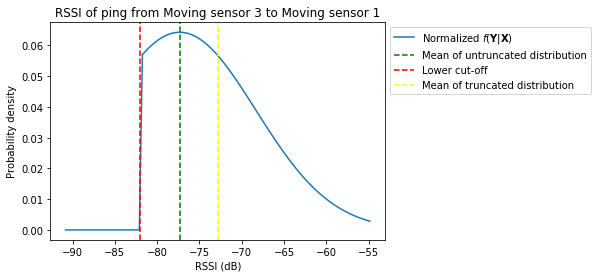

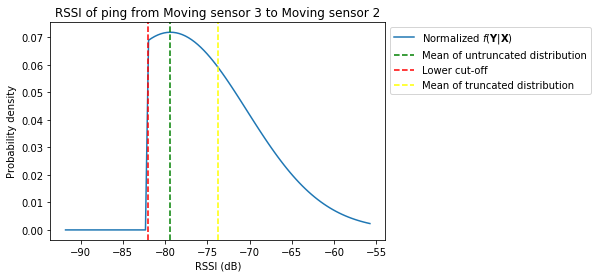

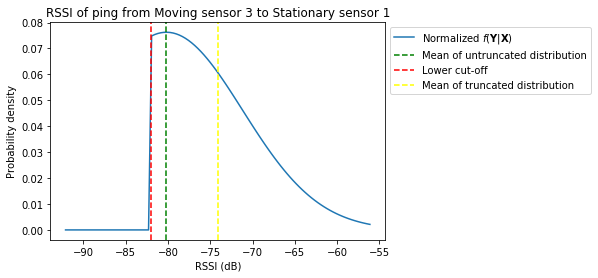

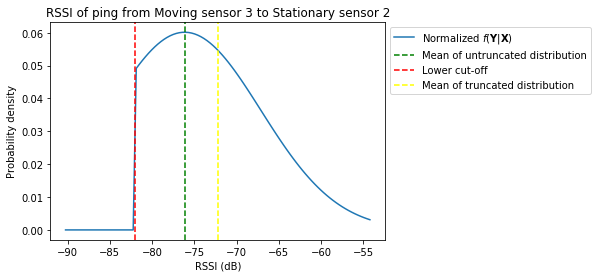

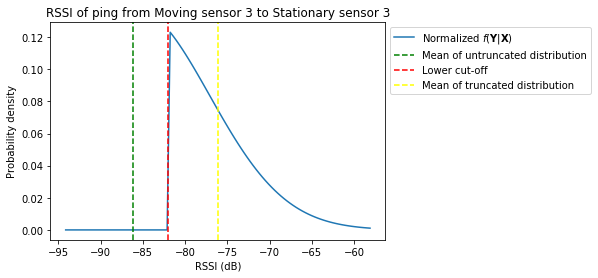

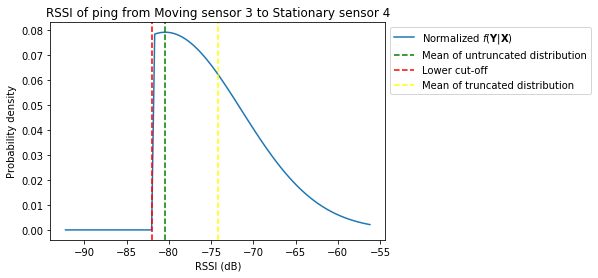

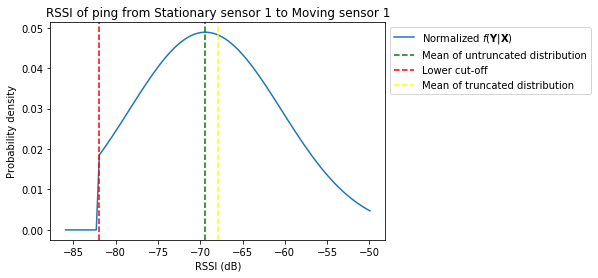

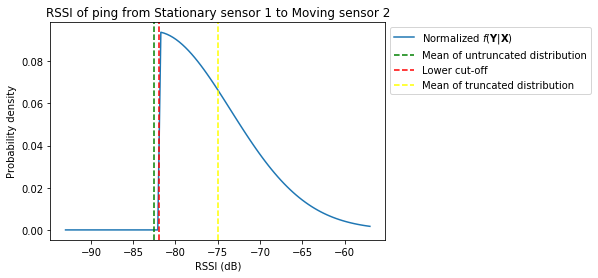

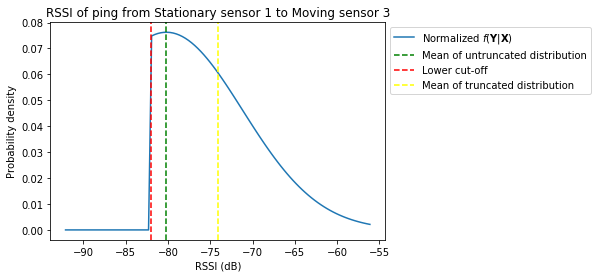

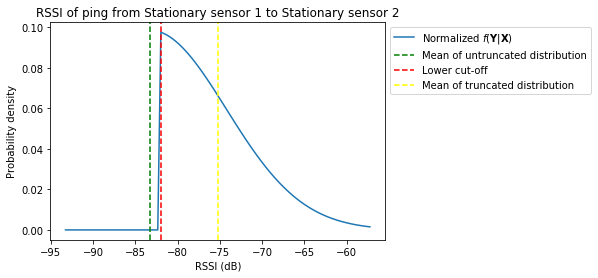

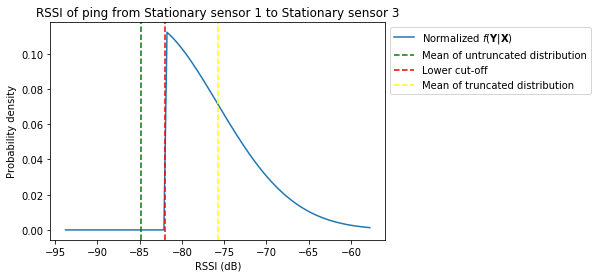

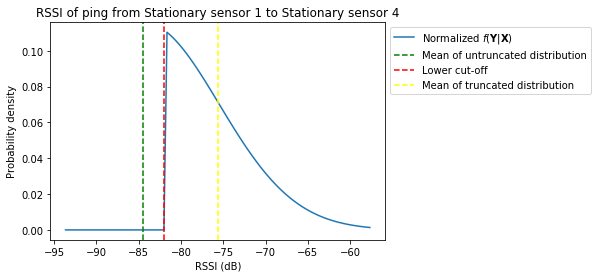

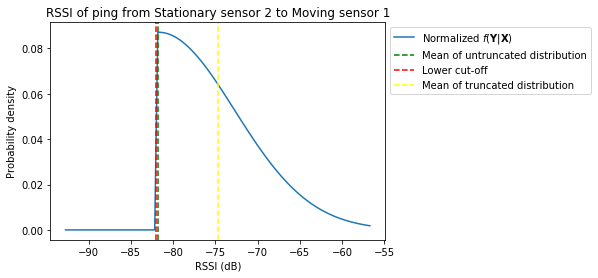

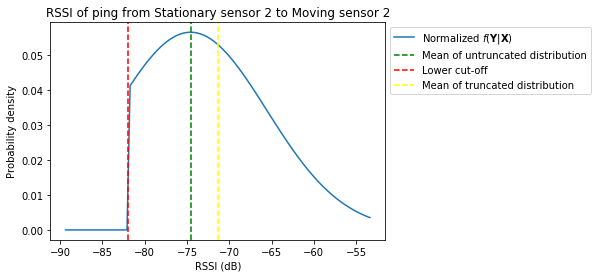

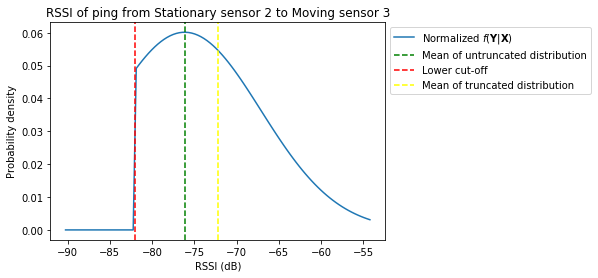

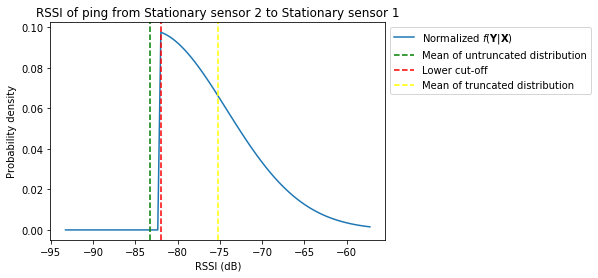

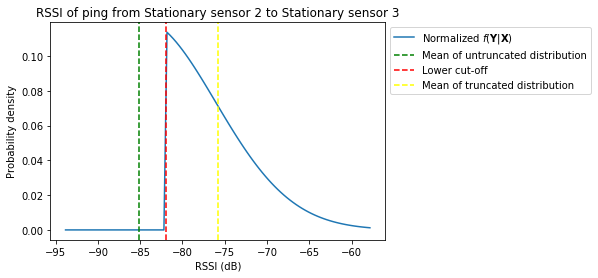

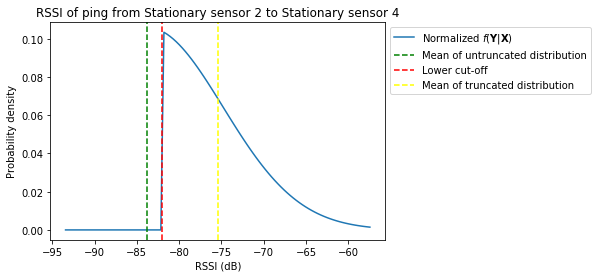

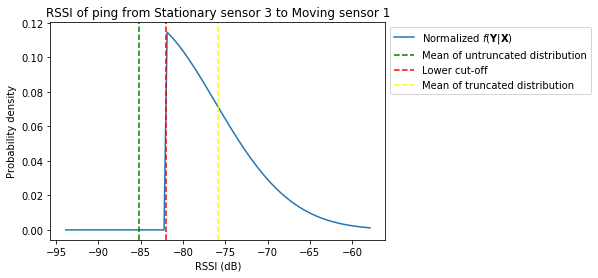

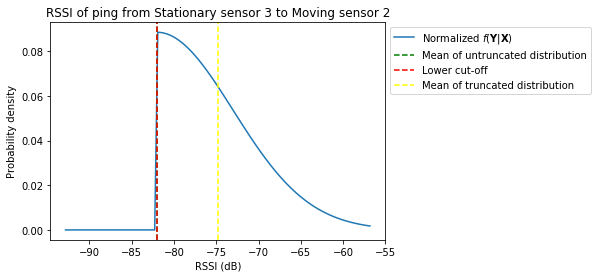

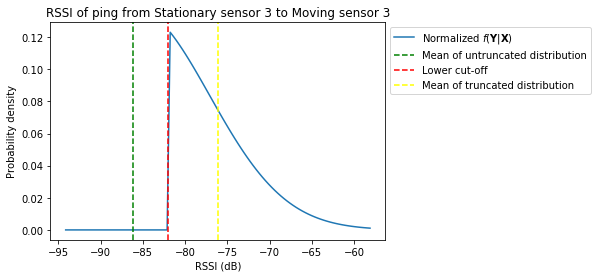

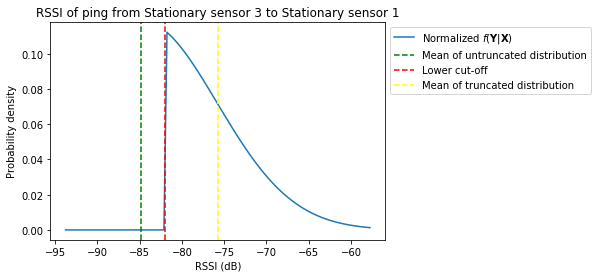

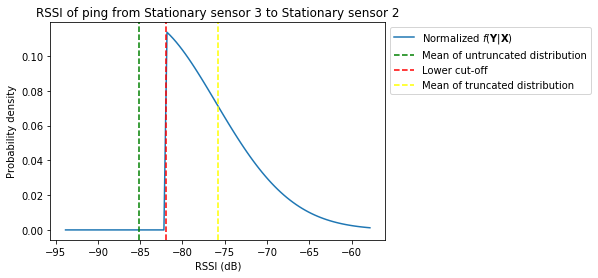

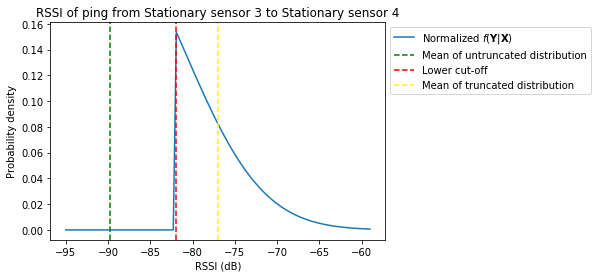

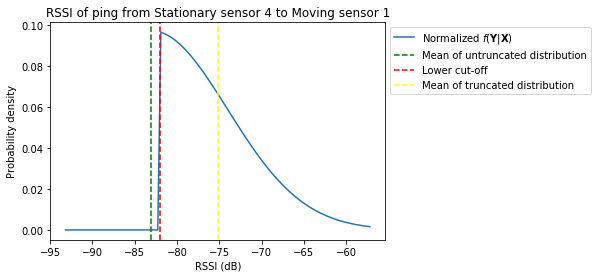

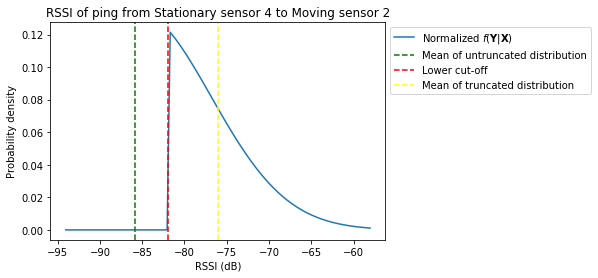

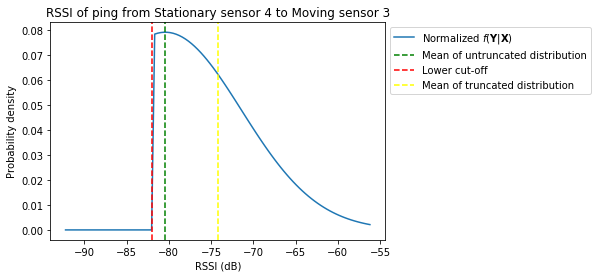

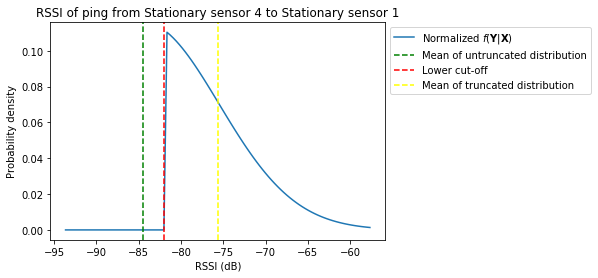

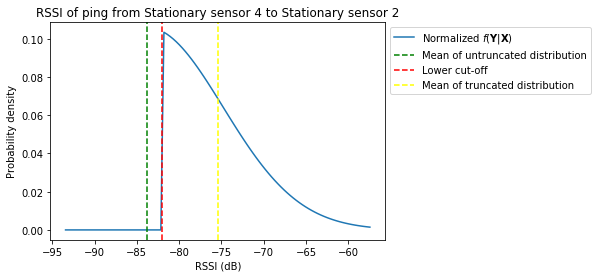

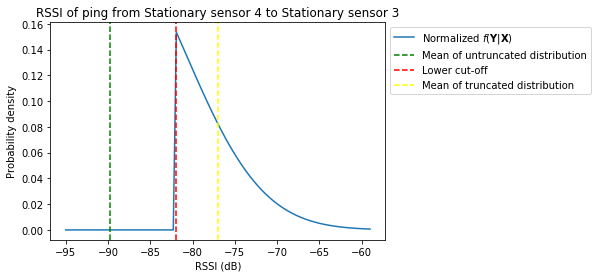

In [56]:
mean_rssi_values = rssi_truncated_mean(distances_test_x_value)
for y_continuous_var_index in range(num_y_continuous_vars):
    test_y_discrete_value = np.repeat(0, num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(mean_rssi_values[y_continuous_var_index] - 2*rssi_untruncated_std_dev,
                           mean_rssi_values[y_continuous_var_index] + 2*rssi_untruncated_std_dev,
                           100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_continuous_var_index] = rssi_range[rssi_index]
        probability_density_range[rssi_index] = math.exp(log_f_y_bar_x(test_x_value,
                                                                       test_y_discrete_value,
                                                                       test_y_continuous_value))
    probability_density_range = probability_density_range/(np.sum(probability_density_range)*(rssi_range[1]-rssi_range[0]))
    plt.plot(rssi_range, probability_density_range, label='Normalized $f(\mathbf{Y} | \mathbf{X})$')
    plt.axvline(x=rssi_untruncated_mean(distances_test_x_value[y_continuous_var_index]),
                linestyle='dashed',
                color='green',
                label='Mean of untruncated distribution')
    plt.axvline(lower_rssi_cutoff,
                linestyle='dashed',
                color='red',
                label='Lower cut-off')
    plt.axvline(x=rssi_truncated_mean(distances_test_x_value[y_continuous_var_index]),
                linestyle='dashed',
                color='yellow',
                label='Mean of truncated distribution')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Probability density')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Set the number of timesteps and initialize the variables.

In [57]:
num_timesteps = 100
t = np.zeros(num_timesteps, dtype='float')
x_t = np.zeros((num_timesteps, num_x_vars), dtype='float')
y_discrete_t = np.zeros((num_timesteps, num_y_discrete_vars), dtype='int')
y_continuous_t = np.zeros((num_timesteps, num_y_continuous_vars), dtype='float')

Calculate the simulated data for $t=0$.

In [58]:
t[0] = 0.0

In [59]:
x_t[0] = x_initial_sample()

In [60]:
y_discrete_t[0] = y_discrete_bar_x_sample(x_t[0])

In [61]:
y_continuous_t[0] = y_continuous_bar_x_sample(x_t[0])

Calculate the simulated data for $t>0$.

In [62]:
timestep_size = 1.0

In [63]:
for t_index in range(1,num_timesteps):
    t[t_index] = t[t_index - 1] + timestep_size
    x_t[t_index] = x_bar_x_prev_sample(x_t[t_index - 1])
    y_discrete_t[t_index] = y_discrete_bar_x_sample(x_t[t_index])
    y_continuous_t[t_index] = y_continuous_bar_x_sample(x_t[t_index])

Find the overall maximum and minimum $h$ and $v$ values across the entire simulation.

In [64]:
h_v_min_max = np.array([[np.min(x_t[:,range(0, num_x_vars, 2)]),
                         np.max(x_t[:,range(0, num_x_vars, 2)])],
                        [np.min(x_t[:,range(1, num_x_vars, 2)]),
                         np.max(x_t[:,range(1, num_x_vars, 2)])]])

Plot the positions of the sensors to make sure they have the properties we expect.

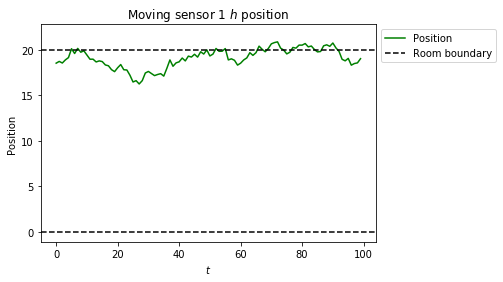

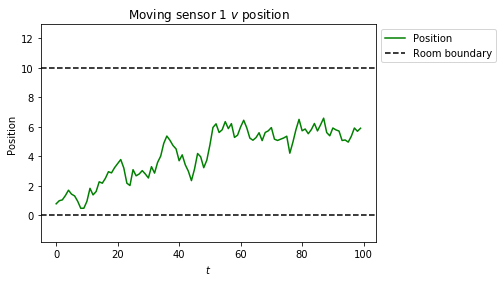

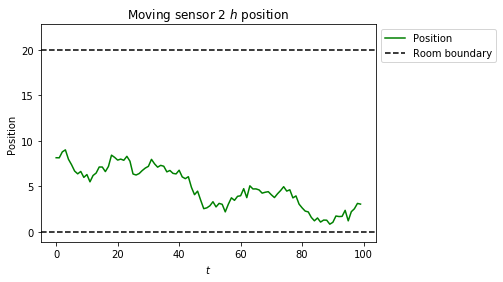

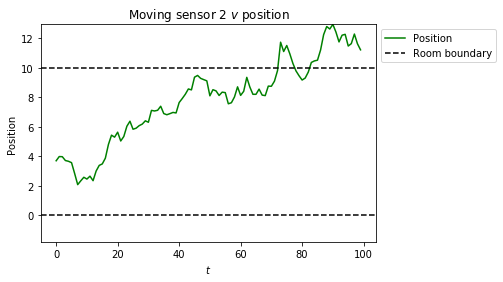

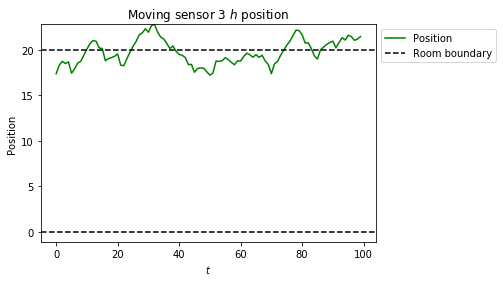

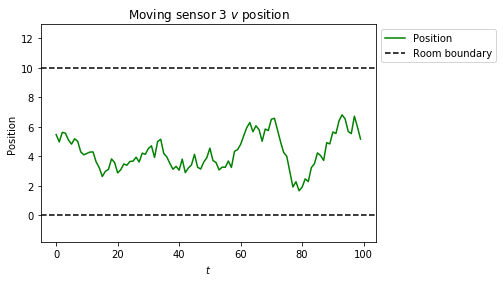

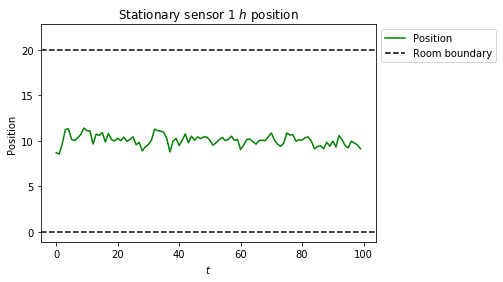

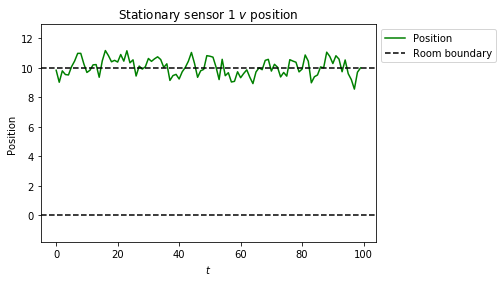

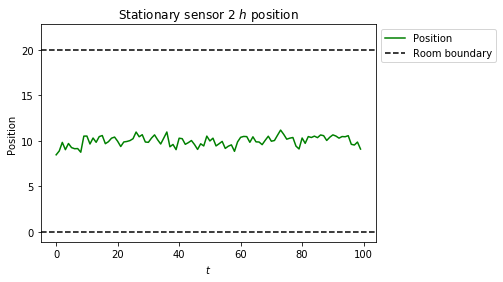

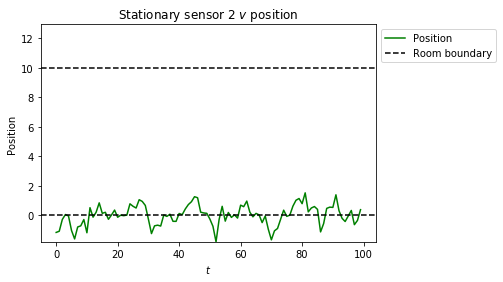

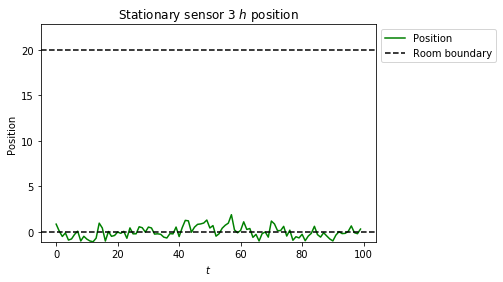

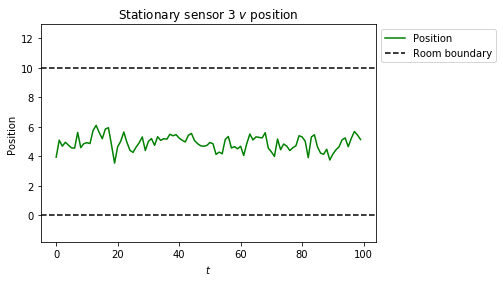

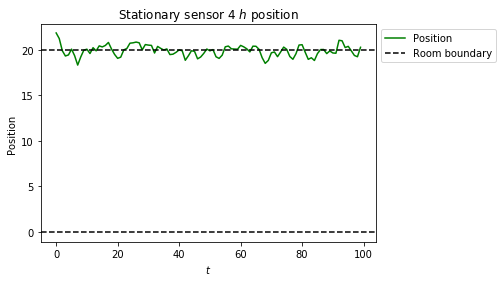

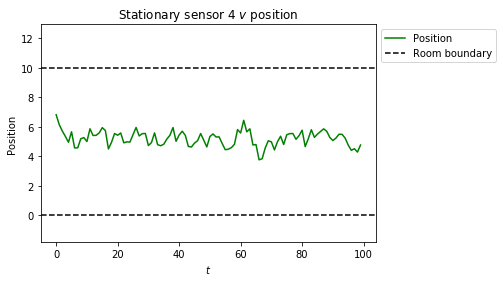

In [65]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:, x_var_index], 'g-', label='Position')
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.plot
    plt.xlabel('$t$')
    plt.ylabel('Position')
    plt.title(x_names[x_var_index])
    plt.ylim(np.min([0, h_v_min_max[x_var_index % 2, 0]]),
             np.max([room_size[x_var_index % 2], h_v_min_max[x_var_index % 2, 1]]))
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For each pair of sensors, plot the measured ping statuses against the distance between the sensors. We should see more missed pings for larger distances, but with a lot of noise.

In [66]:
distances_t = distances(x_t)

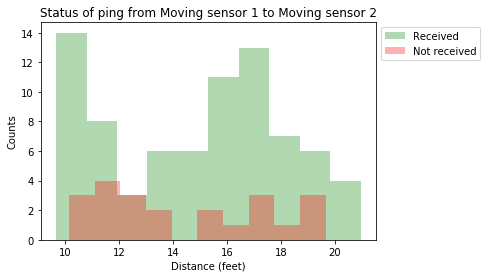

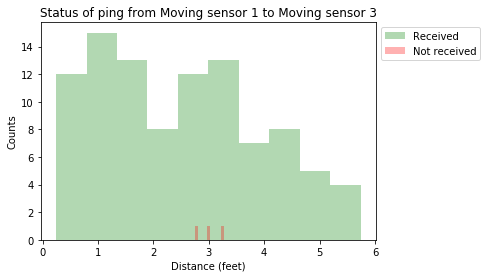

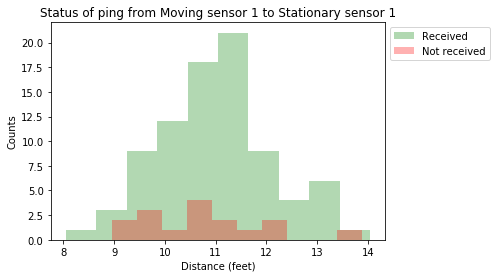

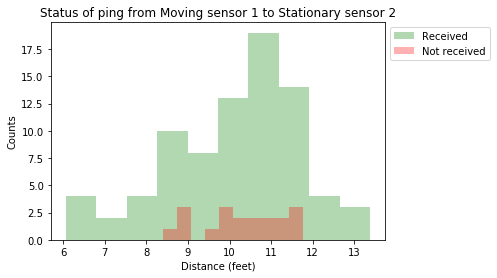

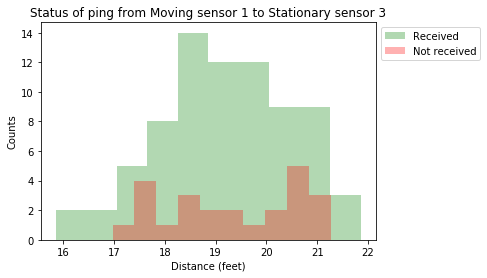

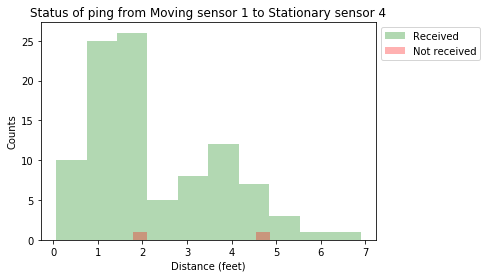

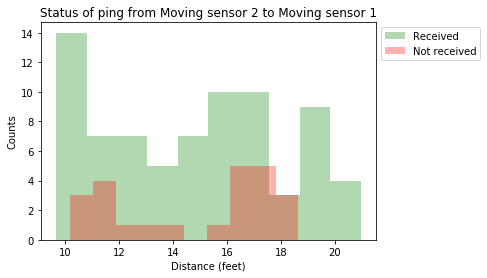

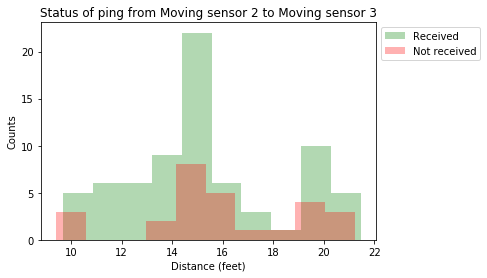

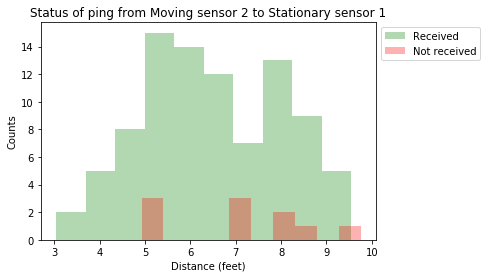

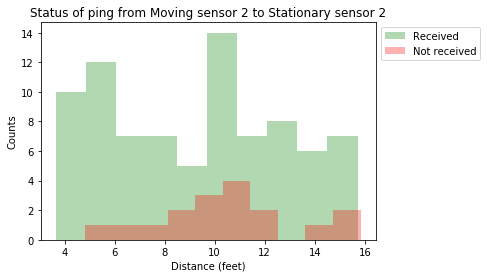

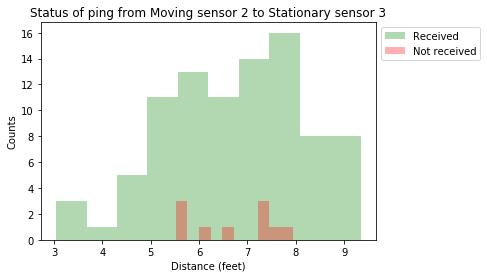

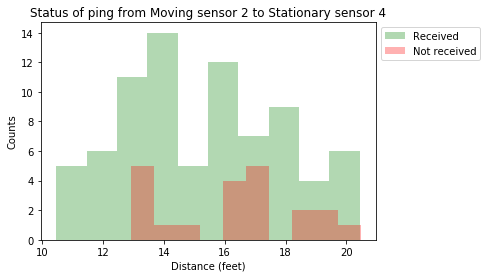

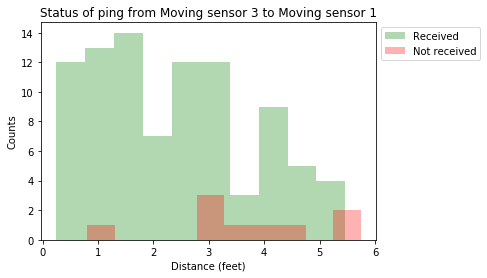

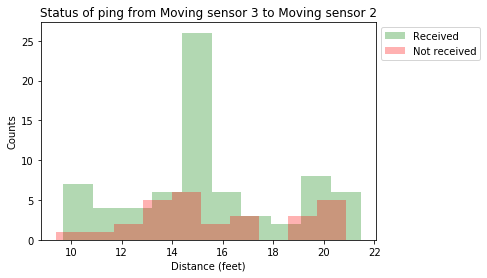

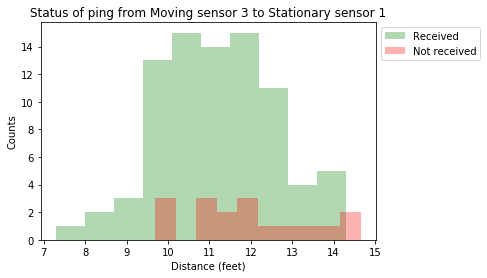

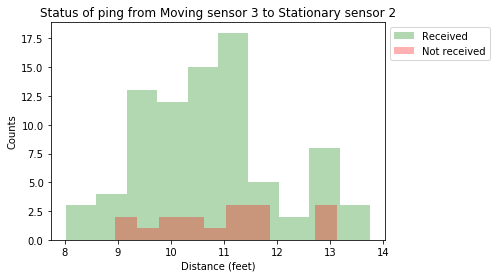

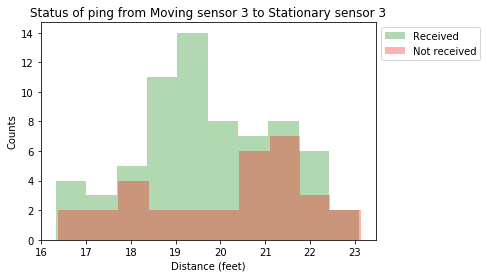

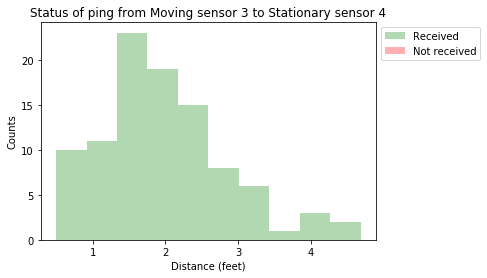

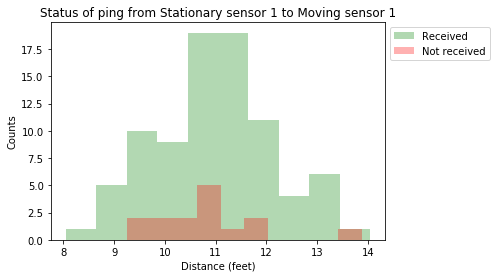

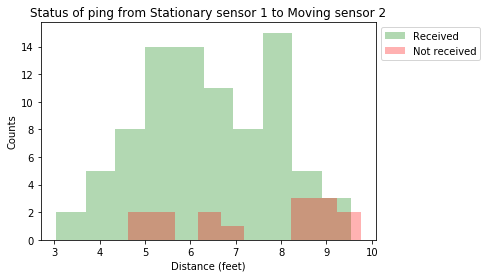

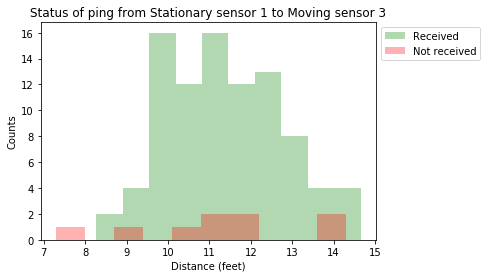

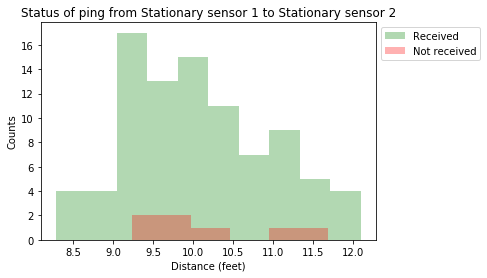

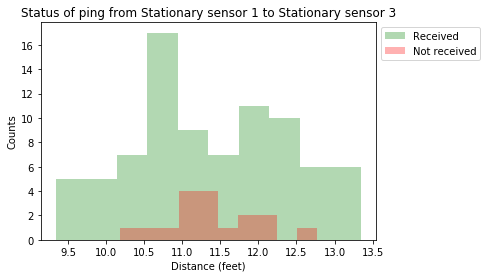

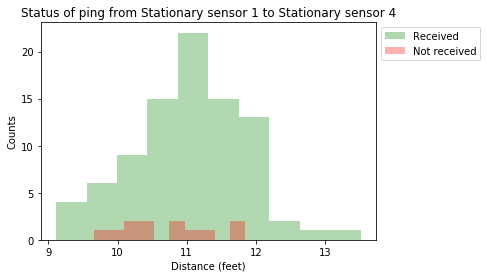

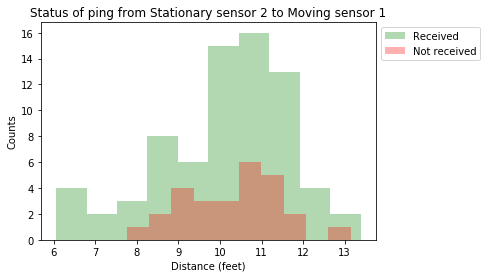

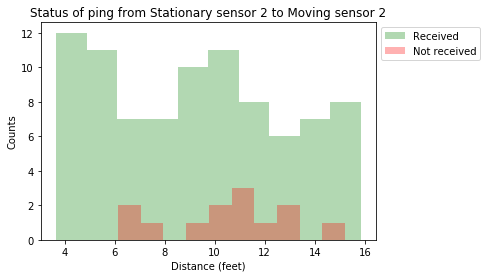

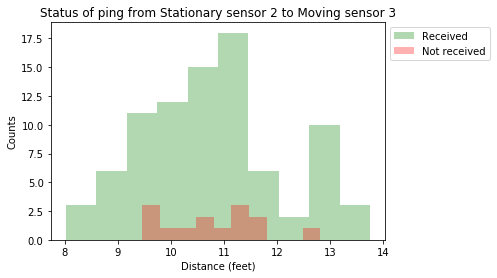

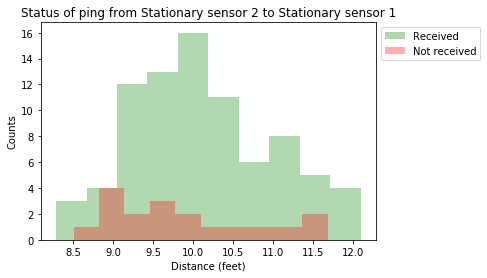

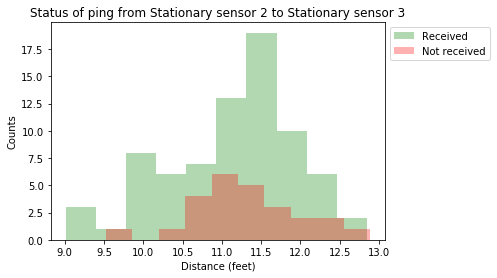

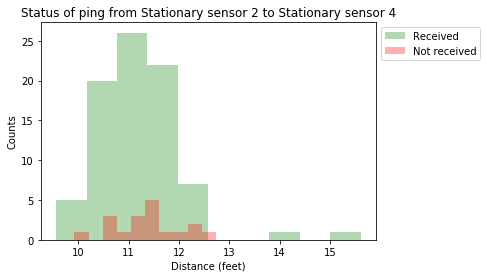

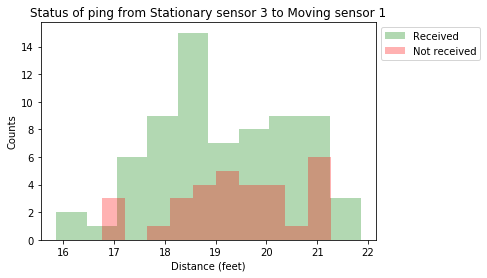

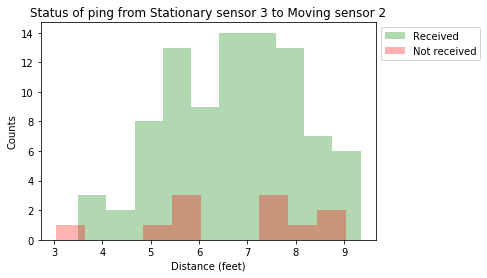

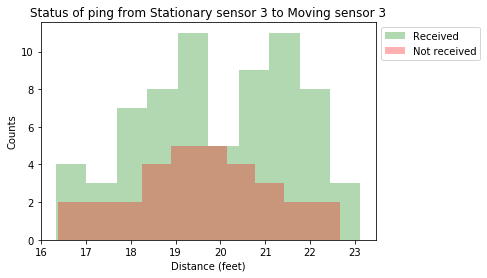

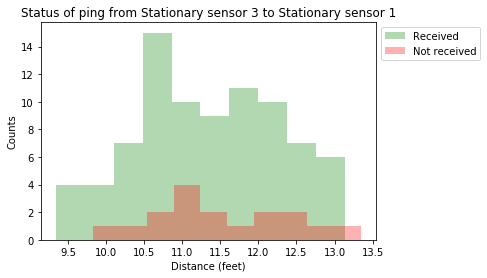

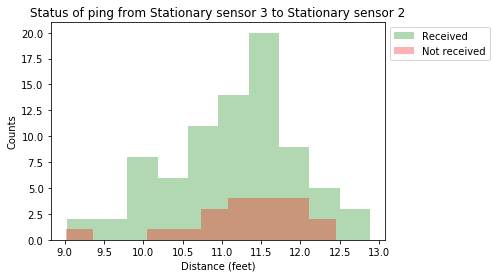

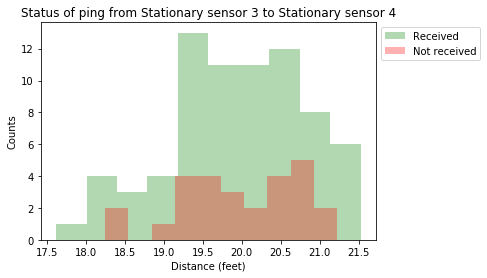

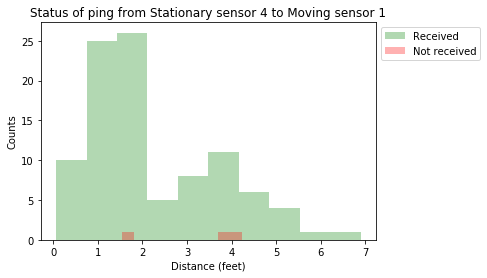

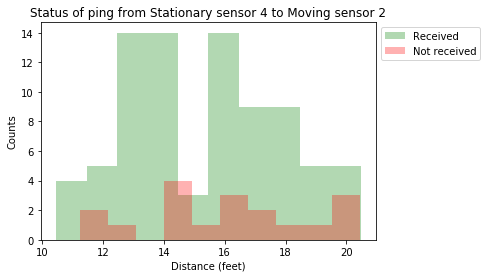

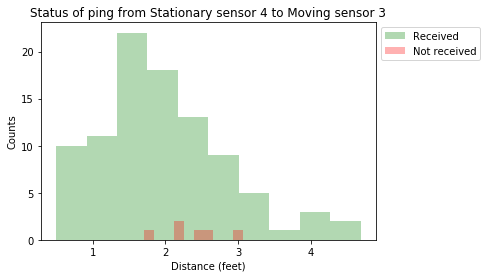

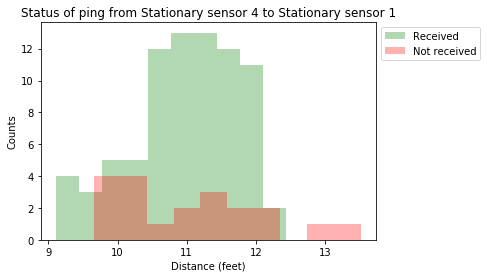

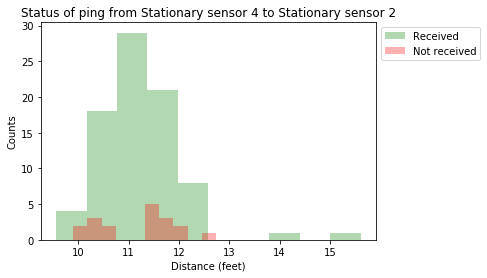

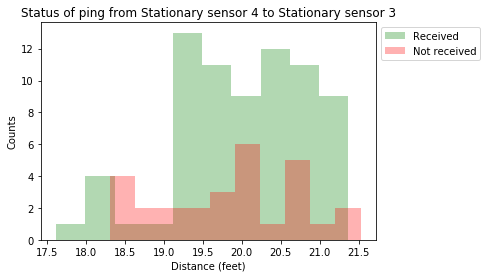

In [67]:
for y_discrete_var_index in range(num_y_discrete_vars):
    plt.hist(distances_t[y_discrete_t[:,y_discrete_var_index] == 0, y_discrete_var_index],
            color='green',
            alpha=0.3,
            label=ping_status_names[0])
    plt.hist(distances_t[y_discrete_t[:,y_discrete_var_index] == 1, y_discrete_var_index],
            color='red',
            alpha=0.3,
            label=ping_status_names[1])
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.xlabel('Distance (feet)')
    plt.ylabel('Counts')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For each pair of sensors, plot the measured RSSI of the received pings versus the distance between the sensors. We should see a wide range of RSSI readings at each distance, but with a mean value that falls off with distance and a hard cut-off at -82 dB.

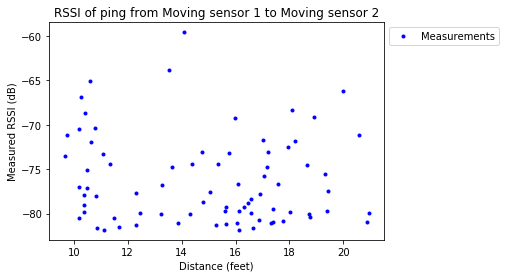

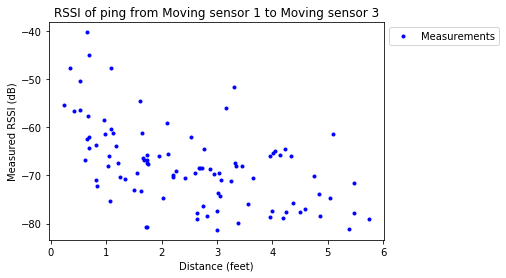

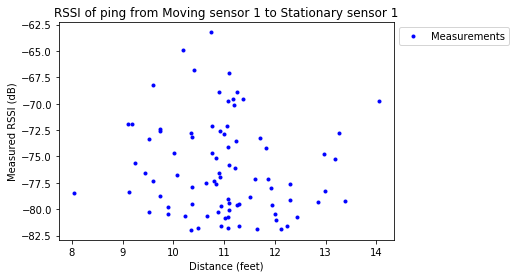

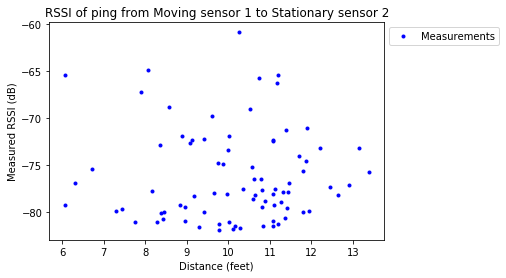

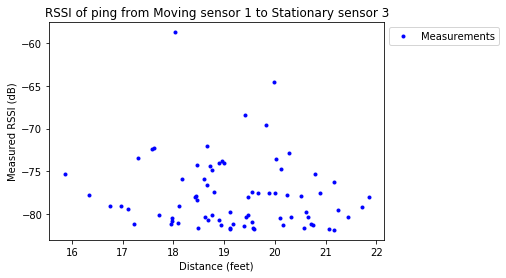

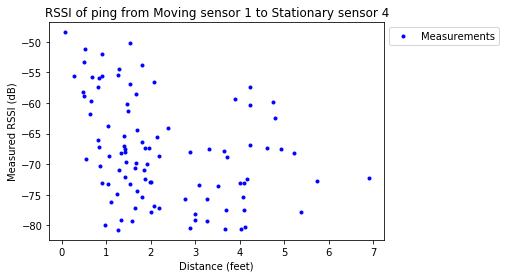

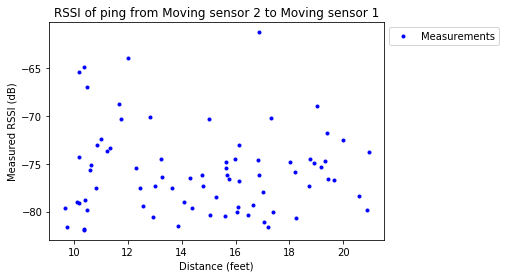

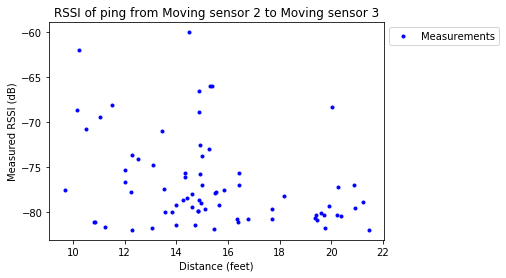

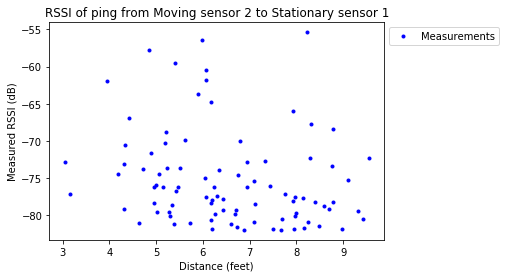

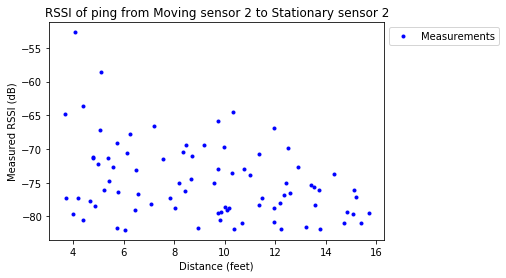

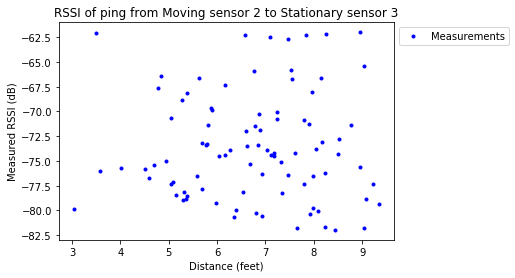

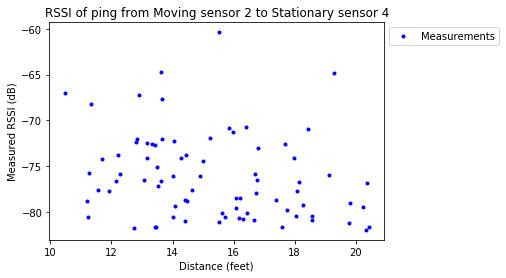

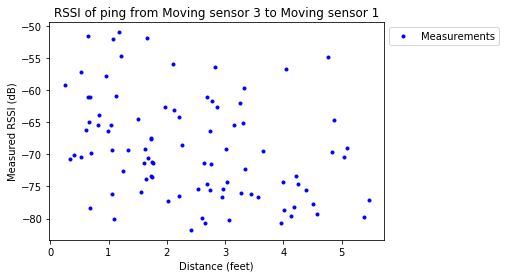

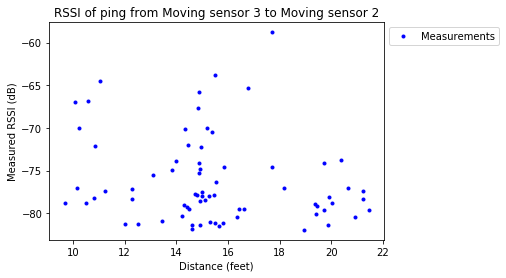

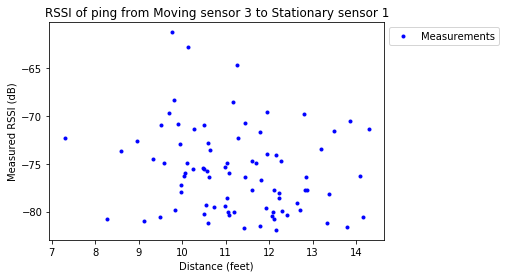

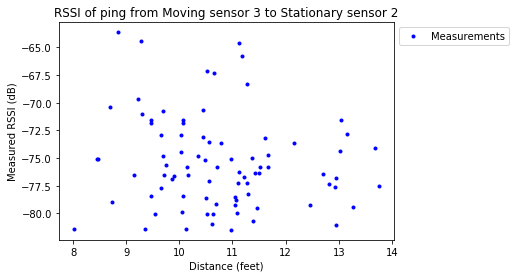

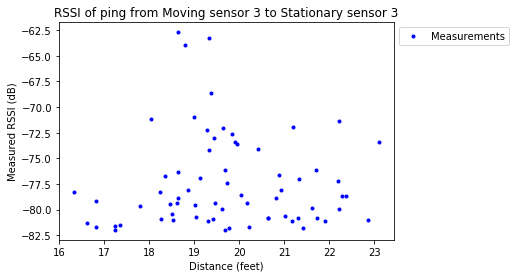

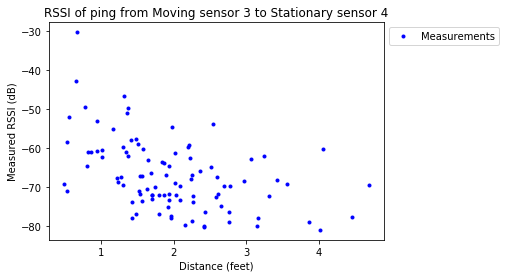

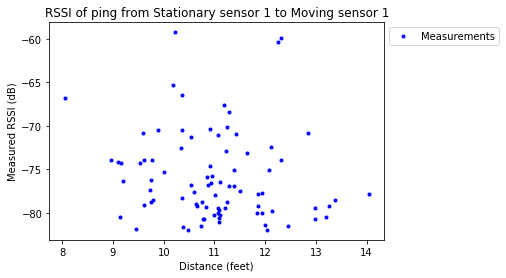

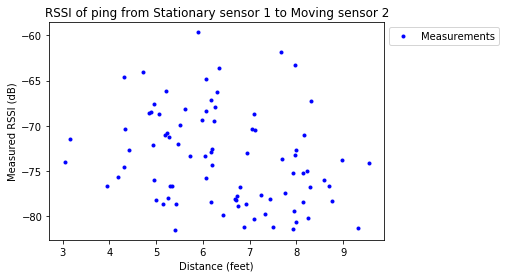

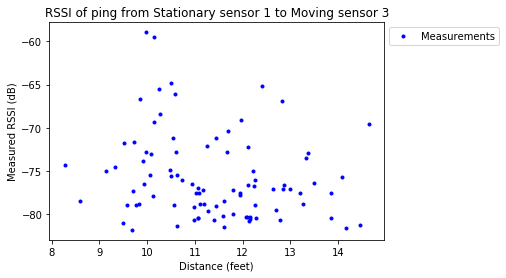

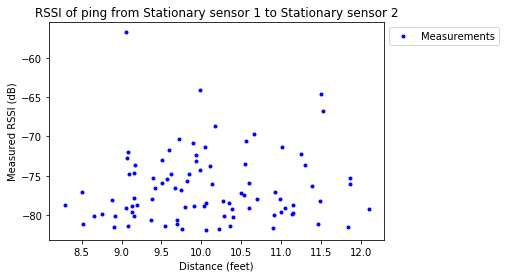

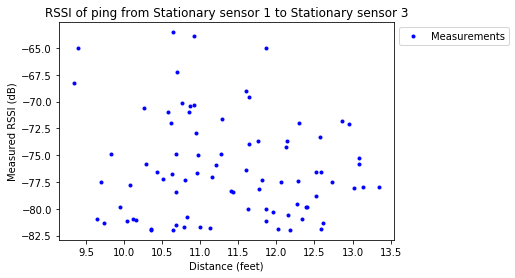

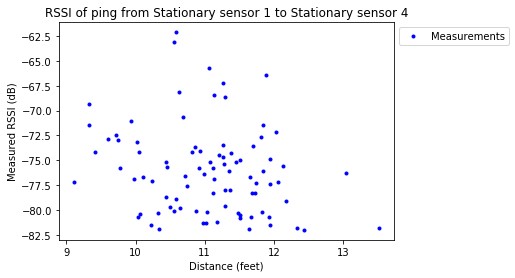

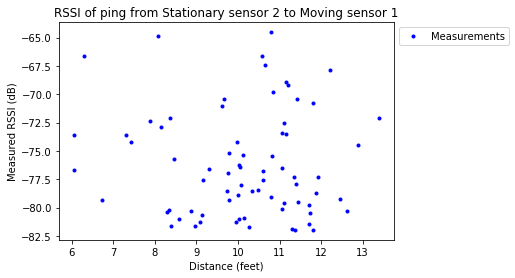

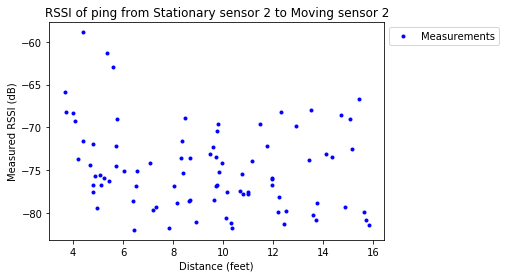

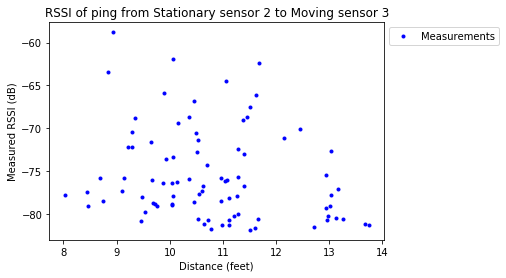

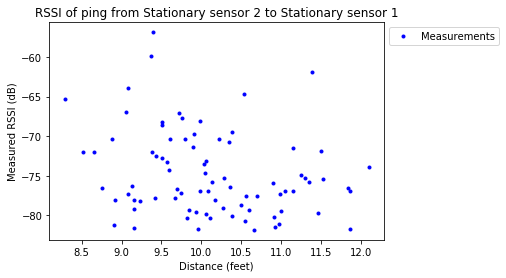

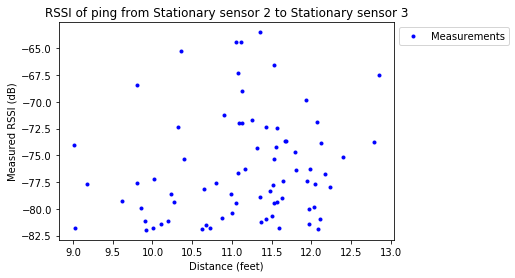

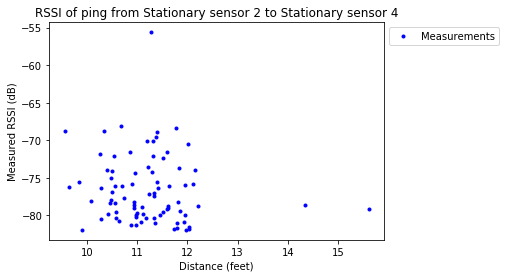

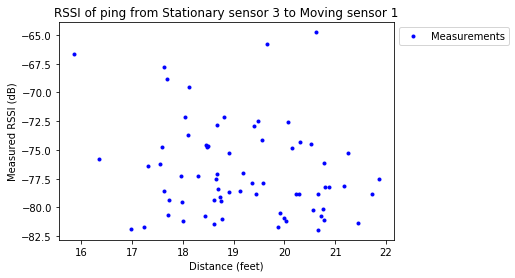

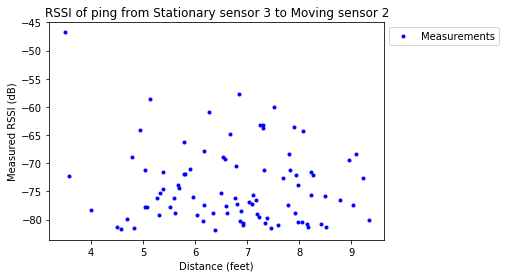

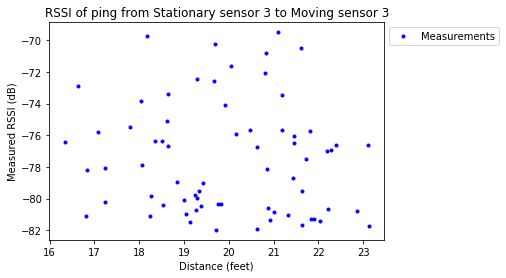

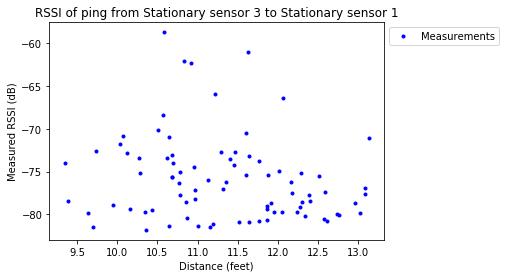

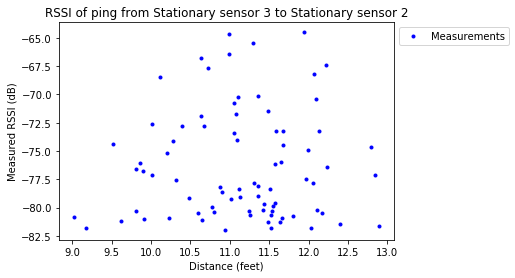

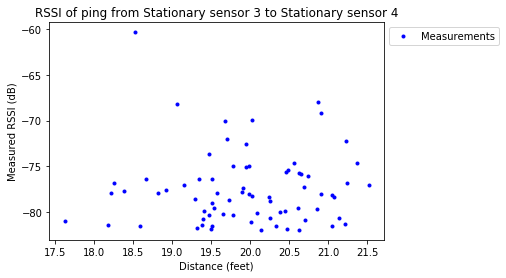

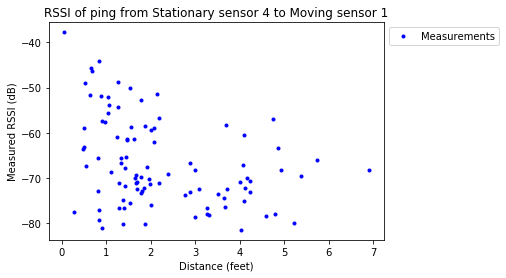

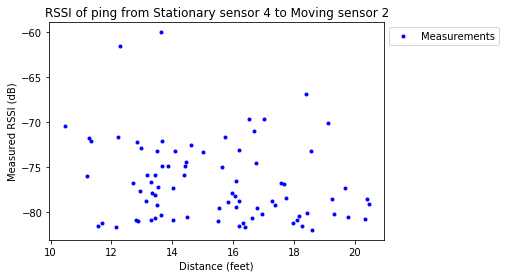

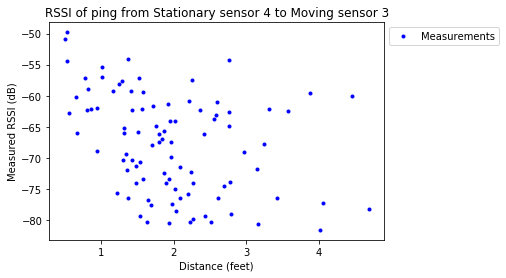

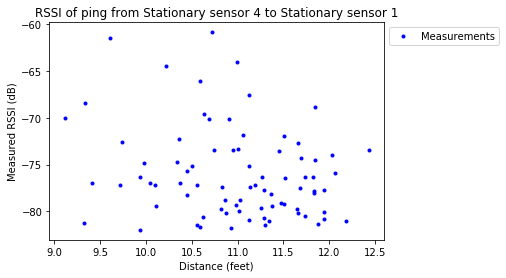

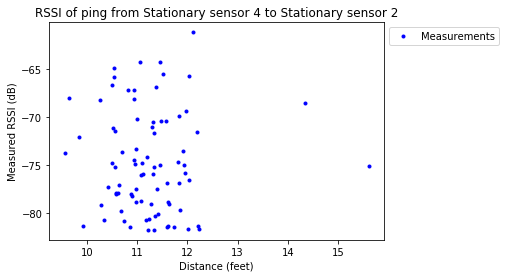

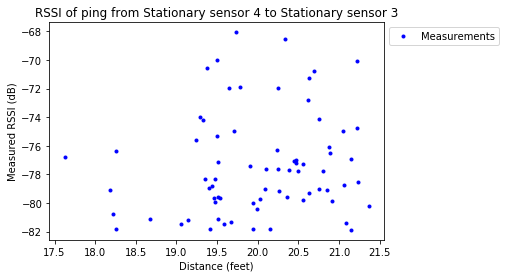

In [68]:
for y_continuous_var_index in range(num_y_continuous_vars):
    plt.plot(distances_t[y_discrete_t[:,y_continuous_var_index] == 0, y_continuous_var_index],
             y_continuous_t[y_discrete_t[:,y_continuous_var_index] == 0, y_continuous_var_index],
             'b.',
            label='Measurements')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.xlabel('Distance (feet)')
    plt.ylabel('Measured RSSI (dB)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ using a particle filter

Set the number of particles and initialize variables.

In [69]:
num_particles = 1000
particle_values = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
log_particle_weights = np.zeros((num_timesteps, num_particles), dtype = 'float')
sampled_particle_indices = np.zeros((num_timesteps, num_particles), dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [70]:
time_start = time.clock()
for particle_index in range(num_particles):
    particle_values[0, particle_index] = x_initial_sample()
    log_particle_weights[0, particle_index] = log_f_y_bar_x(particle_values[0, particle_index],
                                                                 y_discrete_t[0],
                                                                 y_continuous_t[0])
log_particle_weights[0] = log_particle_weights[0] - misc.logsumexp(log_particle_weights[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.666382364687


Calculate the particles for all times $t>0$.

In [71]:
sys.stdout.write('t_index =')
sys.stdout.flush()
time_start = time.clock()
for t_index in range(1, num_timesteps):
    sys.stdout.write(' {}'.format(t_index))
    sys.stdout.flush()
    sampled_particle_indices[t_index - 1] = np.random.choice(num_particles,
                                                             size=num_particles,
                                                             p=np.exp(log_particle_weights[t_index - 1]))
    particle_values[t_index] = x_bar_x_prev_sample(particle_values[t_index - 1,
                                                                   sampled_particle_indices[t_index - 1]])
    log_particle_weights[t_index] = log_f_y_bar_x(particle_values[t_index],
                                                  np.tile(y_discrete_t[t_index], (num_particles,1)),
                                                  np.tile(y_continuous_t[t_index], (num_particles,1)))
    log_particle_weights[t_index] = log_particle_weights[t_index]- misc.logsumexp(log_particle_weights[t_index])
print'\nTime elapsed = {}'.format(time.clock()-time_start)

t_index = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99
Time elapsed = 1.50909695224


Calculate and plot the maximum particle weight for each time step. When the maximum particle weight increases to 1.0, our particle filter has collapsed around a single value.

In [72]:
max_weights = np.max(np.exp(log_particle_weights), axis=1)

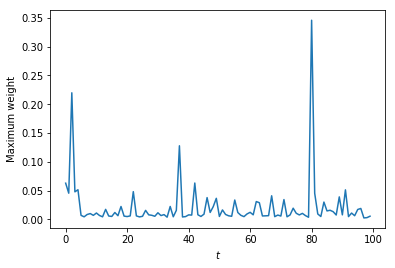

In [73]:
plt.plot(t, max_weights)
plt.xlabel('$t$')
plt.ylabel('Maximum weight')
plt.show()

Calculate and plot the number of particles actually sampled at each time step. If the number of particles actually sampled decreases to 1, our particle filter has collapsed around a single value.

In [74]:
num_sampled_particles = np.array([len(np.unique(sampled_particle_indices[t_index])) for t_index in range(num_timesteps)])

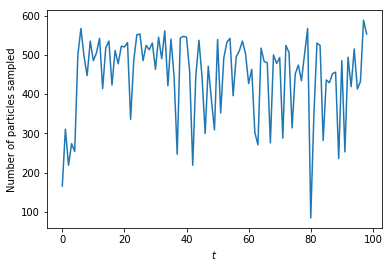

In [75]:
plt.plot(t[:-1], num_sampled_particles[:-1])
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()

Calculate the sample means and sample standard deviations of the particles at each time $t$.

In [76]:
x_mean_particle = np.average(
    particle_values, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights), num_x_vars).reshape((num_timesteps, num_particles, num_x_vars))
)

In [77]:
x_squared_mean_particle = np.average(
    np.square(particle_values), 
    axis=1,
    weights=np.repeat(np.exp(log_particle_weights), num_x_vars).reshape((num_timesteps, num_particles, num_x_vars))
)

In [78]:
x_sd_particle = np.sqrt(np.abs(x_squared_mean_particle - np.square(x_mean_particle)))

Plot the sample means of the particles against the actual values of $\mathbf{X}_t$.

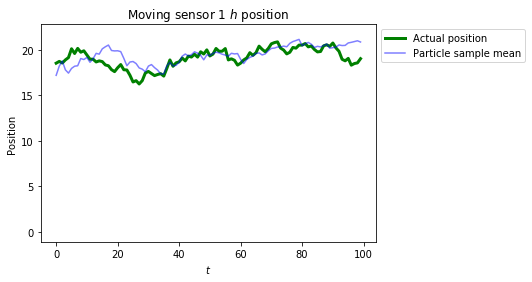

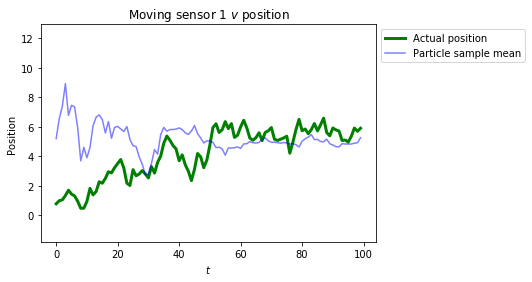

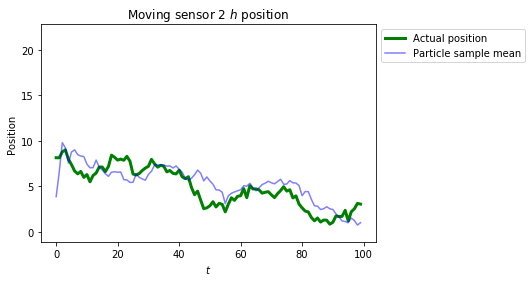

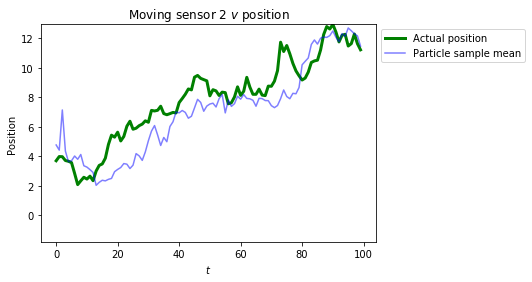

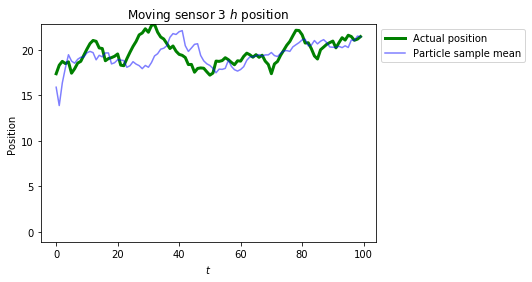

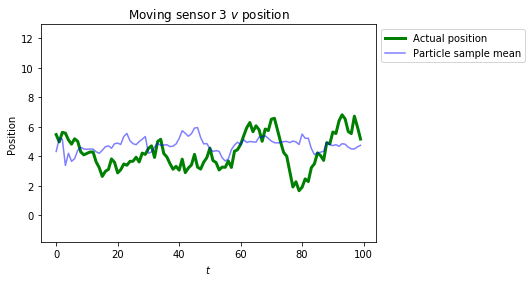

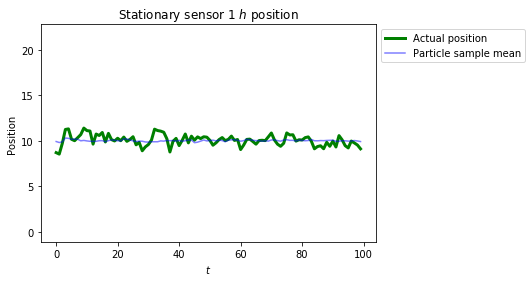

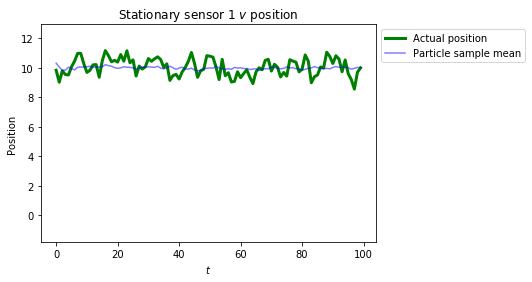

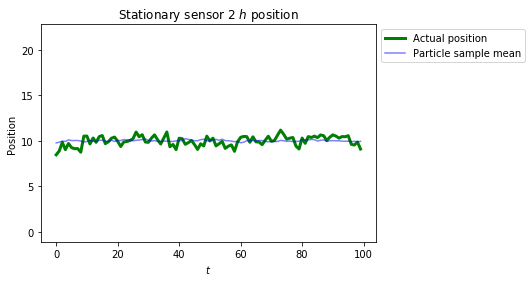

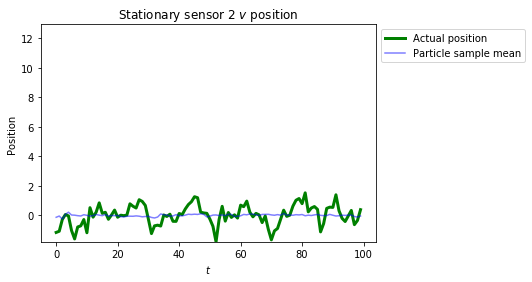

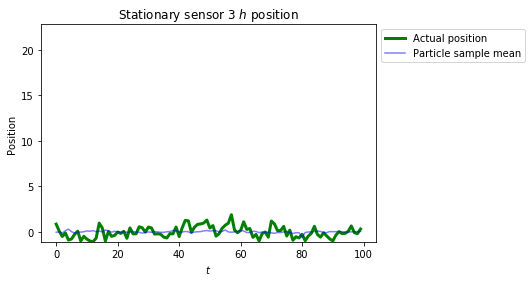

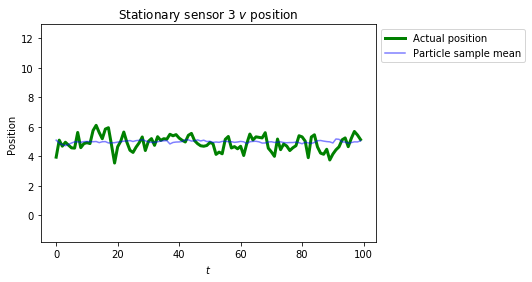

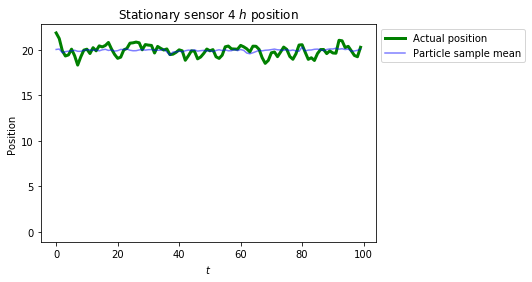

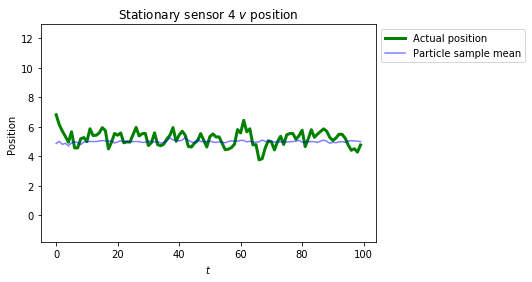

In [79]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.plot(t, x_mean_particle[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.xlabel('$t$')
    plt.ylabel('Position')
    plt.title(x_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.ylim(np.min([0, h_v_min_max[x_var_index % 2, 0]]),
             np.max([room_size[x_var_index % 2], h_v_min_max[x_var_index % 2, 1]]))
    plt.show()

Plot the sample confidence regions of the particles against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

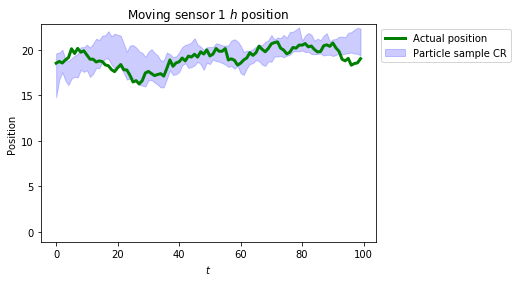

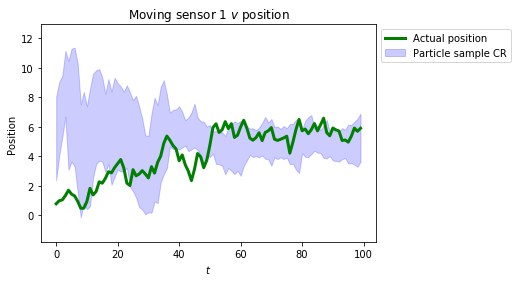

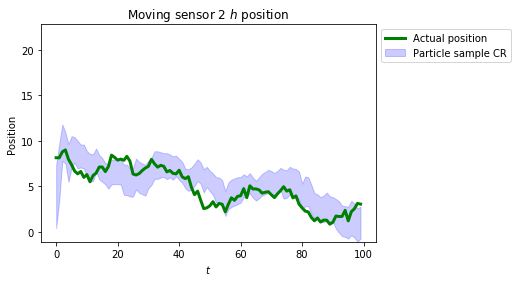

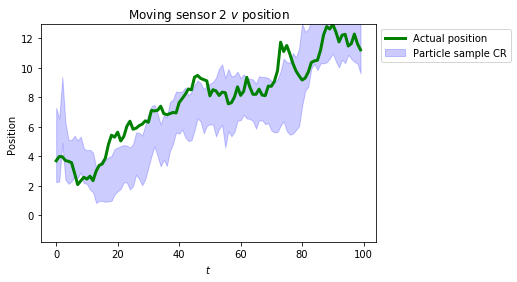

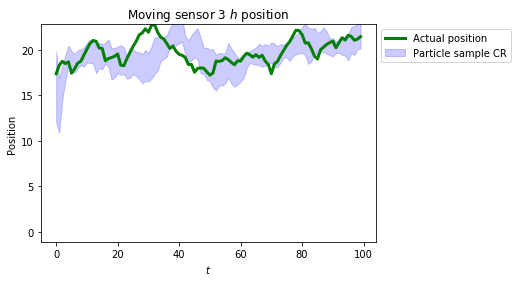

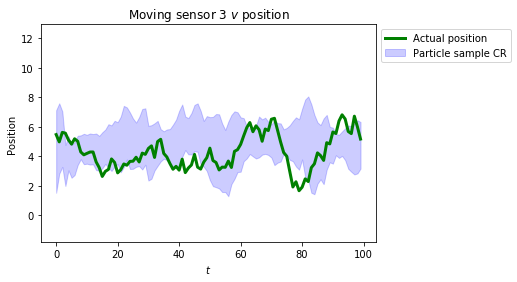

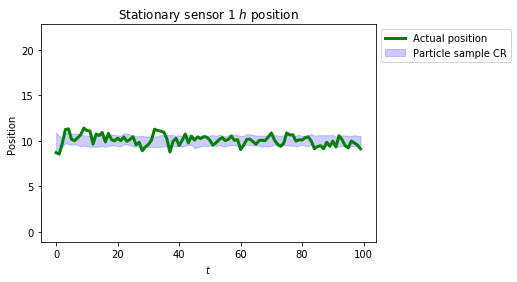

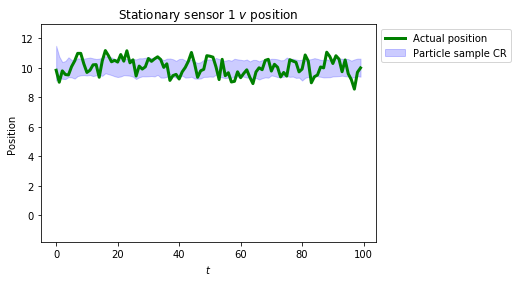

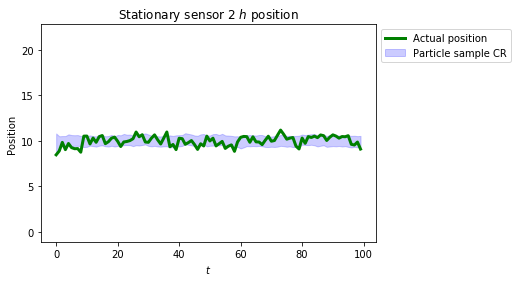

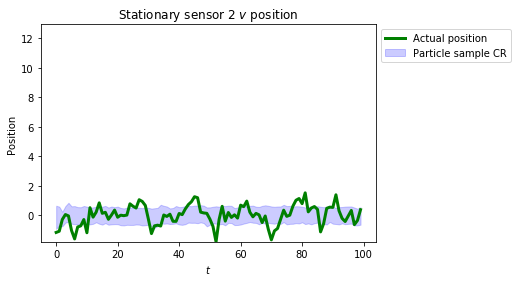

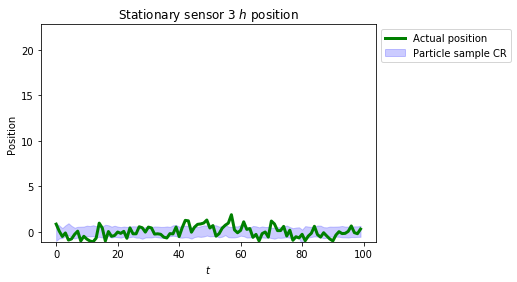

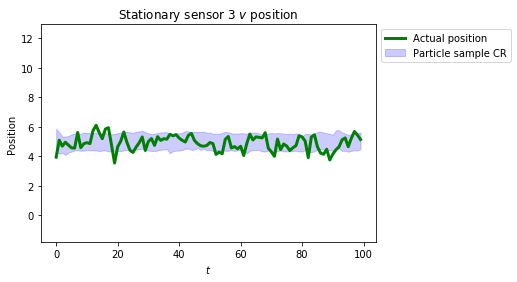

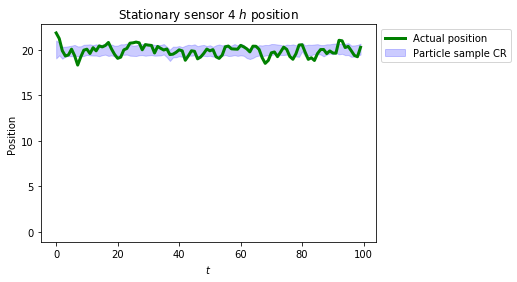

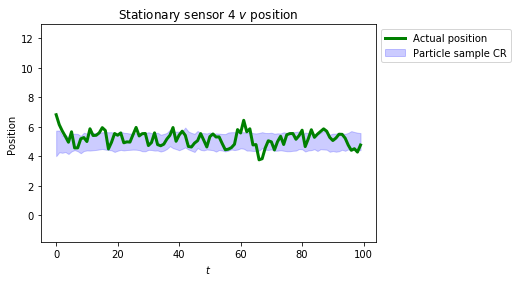

In [80]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.fill_between(
        t,
        x_mean_particle[:,x_var_index] - x_sd_particle[:, x_var_index],
        x_mean_particle[:,x_var_index] + x_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.xlabel('$t$')
    plt.ylabel('Position')
    plt.title(x_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.ylim(np.min([0, h_v_min_max[x_var_index % 2, 0]]),
             np.max([room_size[x_var_index % 2], h_v_min_max[x_var_index % 2, 1]]))
    plt.show()

Visualize the actual particles for a few chosen time steps.

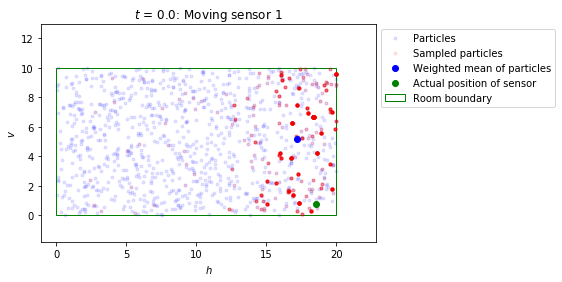

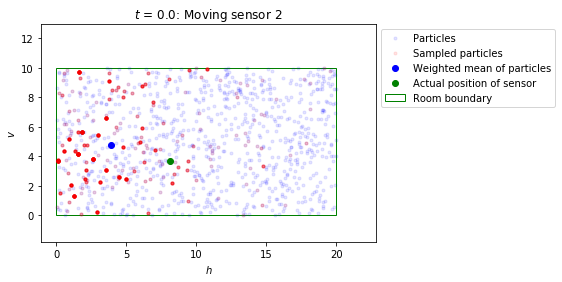

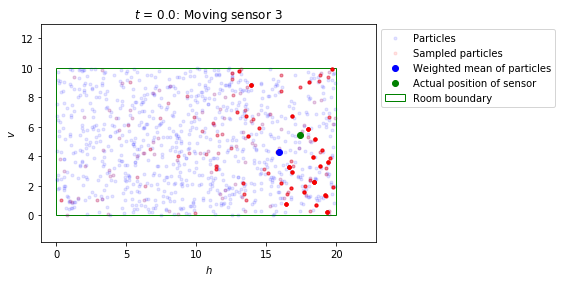

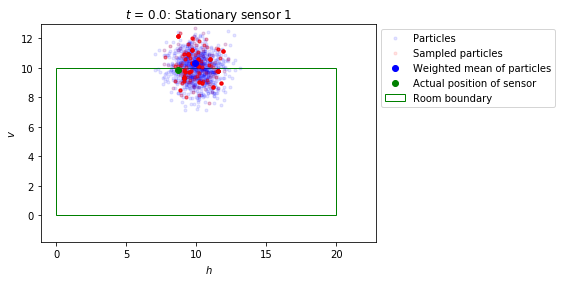

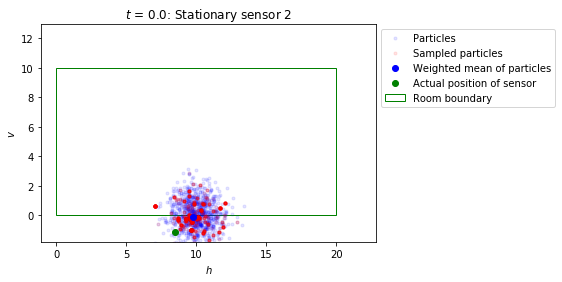

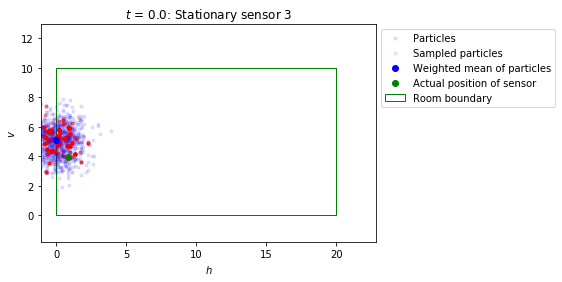

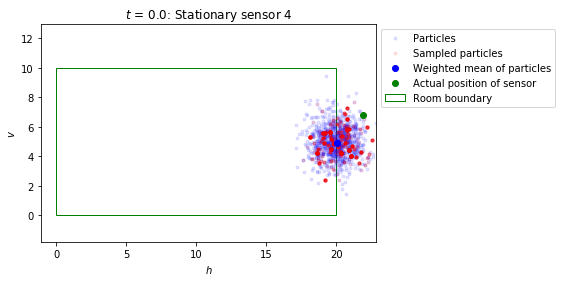

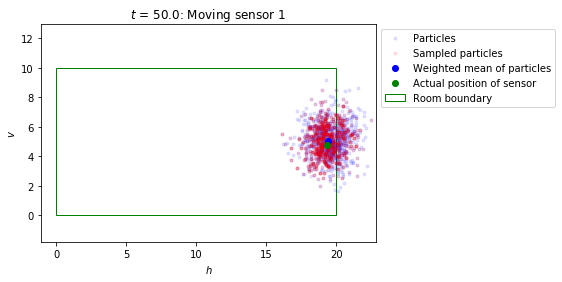

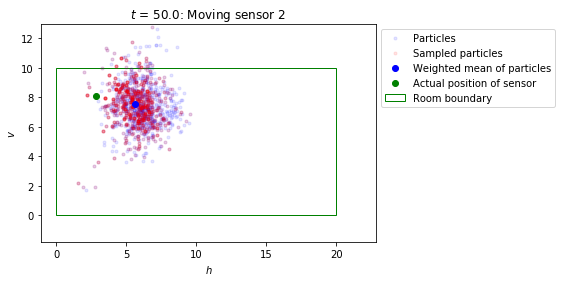

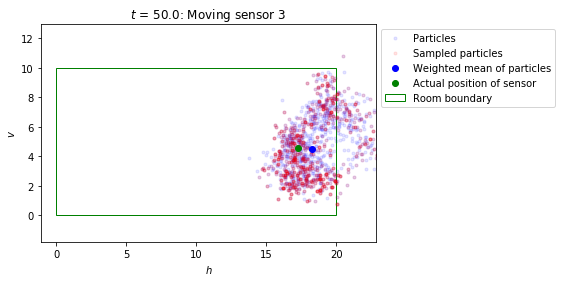

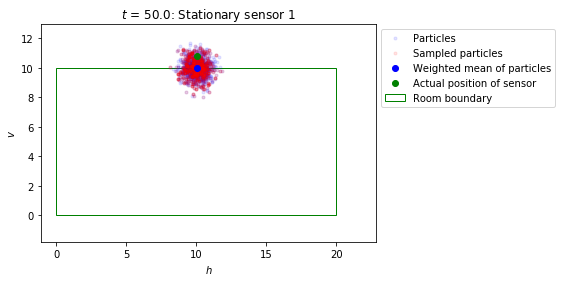

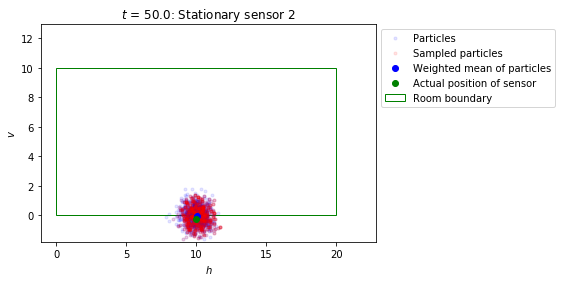

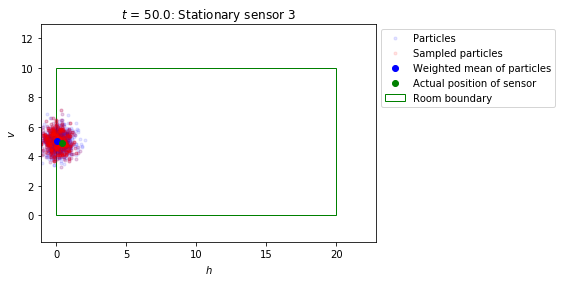

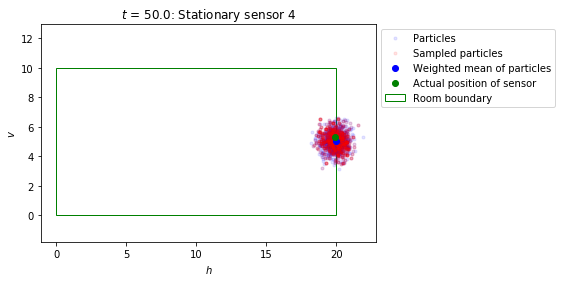

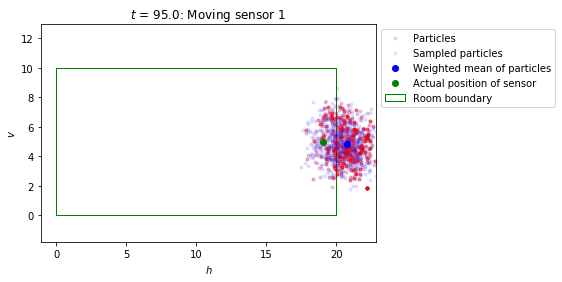

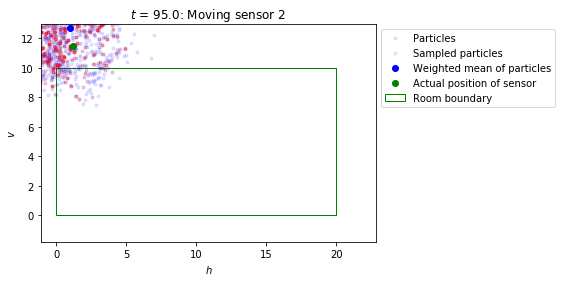

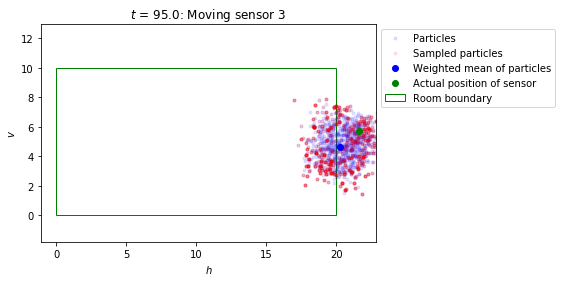

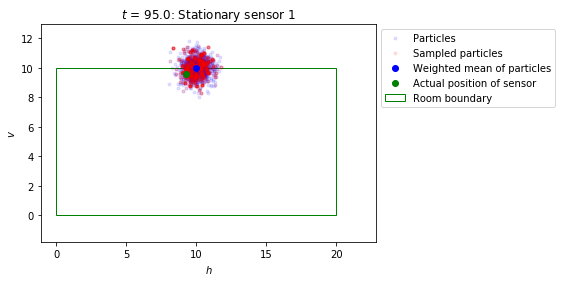

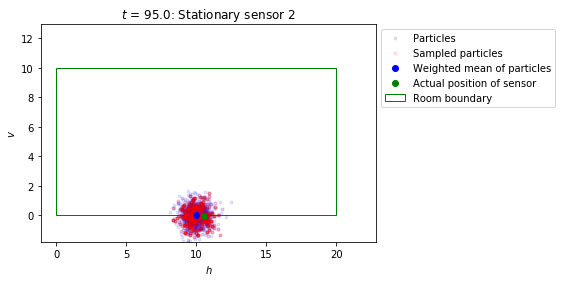

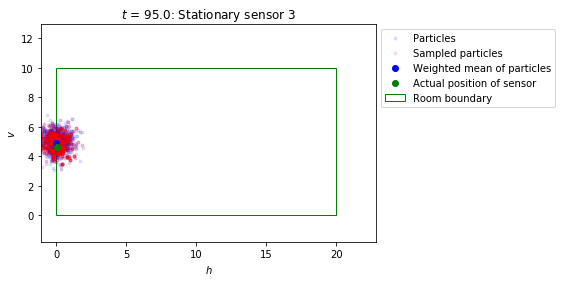

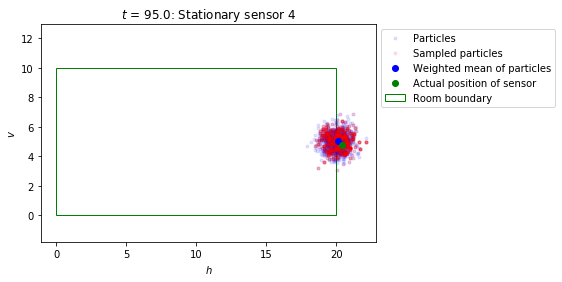

In [81]:
for t_index in [0, 50, 95]:
    for sensor_index in range(num_sensors):
        plt.plot(particle_values[t_index, :, sensor_index*2],
                 particle_values[t_index, :, sensor_index*2 + 1],
                'b.',
                alpha=0.1,
                label='Particles')
        plt.plot(particle_values[t_index, sampled_particle_indices[t_index], sensor_index*2],
                 particle_values[t_index, sampled_particle_indices[t_index], sensor_index*2 + 1],
                'r.',
                alpha=0.1,
                label='Sampled particles')
        plt.plot(x_mean_particle[t_index, sensor_index*2],
                 x_mean_particle[t_index, sensor_index*2 + 1],
                 'bo',
                 label = 'Weighted mean of particles')
        plt.plot(x_t[t_index, sensor_index*2],
                 x_t[t_index, sensor_index*2 + 1],
                 'go',
                 label = 'Actual position of sensor')
        plt.title('$t$ = {}: {}'.format(t[t_index],
                                       sensor_names[sensor_index]))
        plt.xlabel(dimension_names[0])
        plt.ylabel(dimension_names[1])
        plt.xlim(np.min([0, h_v_min_max[0, 0]]),
                 np.max([room_size[0], h_v_min_max[0, 1]]))
        plt.ylim(np.min([0, h_v_min_max[1, 0]]),
                 np.max([room_size[1], h_v_min_max[1, 1]]))
        ax=plt.gca()
        ax.add_patch(patches.Rectangle((0,0),
                                       room_size[0],
                                       room_size[1],
                                       fill=False,
                                       color='green',
                                       label='Room boundary'))
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        plt.show()